# Evaluation of network architecture and data augmentation methods for deep learning in chemogenomics

In [1]:
import pickle
import pandas as pd
import numpy as np

In [2]:
from src.utils.DB_utils import TOX21_DATASETS, PCBA_DATASETS, LIST_REGR_DATASETS, LIST_CLF_DATASETS
from src.utils.DB_utils import LIST_MULTICLF_DATASETS, LIST_BINARYCLF_DATASETS, LIST_AA_DATASETS
from src.utils.DB_utils import LIST_DTI_DATASETS, LIST_MOL_DATASETS, LIST_PROT_DATASETS, LIST_MULTIOUT_DATASETS

Using TensorFlow backend.


# plot functions

In [26]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

def plot_perf_SingleDataset(dataset, df, ratio_tr, ratio_te, setting, figsize=(10,8), 
                            rot=45, x_=None):
    print(dataset)
    f, axs = plt.subplots(1, 1, figsize=figsize)
    df = df[df['dataset']==dataset]
    df = df[df['ratio_tr']==ratio_tr]
    df = df[df['ratio_te']==ratio_te]
    if type(setting) != list:
        df = df[df['setting']==setting]
    else:
        df = df[df.setting.isin(setting)]
    x_ = 'algo' if x_ is None else x_
    print('mean', np.mean(df.score_val), 'std', np.std(df.score_val))
    sns.boxplot(x=x_, y="score_val", hue="score_name", data=df, palette="Set3", ax=axs)
    sns.swarmplot(x=x_, y="score_val", hue="score_name", data=df, ax=axs, dodge=True)
    # sns.boxplot(x='cv', y="score", data=df, palette="Set3", ax=axs)
    axs.set_title(dataset)
    for tick in axs.get_xticklabels():
        tick.set_rotation(rot)
    #ax = plt.gca()
    axs.grid(True)

def plot_perf_SingleAlgo(algo, df, ratio_tr, ratio_te, setting, list_dataset=None, figsize=(10,8)):
    print(algo)
    f, axs = plt.subplots(1, 1, figsize=figsize)
    df = df[df['algo']==algo]
    df = df[df['ratio_tr']==ratio_tr]
    df = df[df['ratio_te']==ratio_te]
    df = df[df['setting']==setting]
    
    if list_dataset is not None:
        ldb = df.dataset.unique()
        for db in ldb:
            if db not in list_dataset:
                df = df[~df.dataset.str.contains(db)]
                
    sns.boxplot(x='dataset', y="score_val", hue="score_name", data=df, palette="Set3", ax=axs)
    sns.swarmplot(x='dataset', y="score_val", hue="score_name", data=df, palette="Set3", ax=axs, dodge=True)
    # sns.boxplot(x='cv', y="score", data=df, palette="Set3", ax=axs)
    axs.set_title(algo)
    for tick in axs.get_xticklabels():
        tick.set_rotation(45)

In [4]:
def plot_perf(dataset, df, ratio_te, setting, ratio_tr=None, x_='setting', hue_='algo', figsize=(10,8), 
              rot=0, print_perf=True, title_prefix='', set_title=False):
    print(dataset)
    
    list_x_, list_hue_, list_score_, list_rtr_ = \
        list(set(list(df[x_]))), list(set(list(df[hue_]))), list(set(list(df["score_name"]))), list(set(list(df["ratio_tr"])))
    
    df = df[df['dataset']==dataset]
    if type(setting) != list:
        df = df[df['setting']==setting]
    else:
        df = df[df.setting.isin(setting)]
    
    for rte in ratio_te:
        f, axs = plt.subplots(1, 1, figsize=figsize)
        print('ratio_te : ', rte)
        df_ = df[df['ratio_te']==rte]

        if ratio_tr is not None:
            df_ = df_[df_['ratio_tr']==ratio_tr]
        else:
            for x_type in list_x_:
                print("\t", x_type)
                df_t = df_[df_[x_]==x_type]
                for hue_type in list_hue_:
                    print('\t', hue_type)
                    df_tt = df_t[df_t[hue_]==hue_type]
                    for score_type in list_score_:
                        print('\t\t', score_type)
                        df_tt_ = df_tt[df_tt["score_name"]==score_type]
                        best_ratio_tr = None
                        max_score = 0 if dataset in LIST_CLF_DATASETS else 1000000 if dataset in LIST_REGR_DATASETS else None
                        rtr_str = ''
                        for rtr_type in list_rtr_:
                            if dataset in LIST_CLF_DATASETS and \
                                    np.mean(df_tt_[df_tt_["ratio_tr"]==rtr_type].score_val) > max_score:
                                best_ratio_tr = rtr_type
                                max_score = np.mean(df_tt_[df_tt_["ratio_tr"]==rtr_type].score_val)
                            elif dataset in LIST_REGR_DATASETS and \
                                    np.mean(df_tt_[df_tt_["ratio_tr"]==rtr_type].score_val) > max_score:
                                best_ratio_tr = rtr_type
                                max_score = np.mean(df_tt_[df_tt_["ratio_tr"]==rtr_type].score_val)
                            rtr_str += str(rtr_type) + ' ; ' + str(round(np.mean(df_tt_[df_tt_["ratio_tr"]==rtr_type].score_val), 4)) + ' // '
                        rtr_str = str(best_ratio_tr) + ' /// ' + rtr_str
                        df_ = df_[((df_[x_]==x_type) & (df_[hue_]==hue_type) & 
                                  (df_["score_name"]==score_type) & (df_['ratio_tr']==best_ratio_tr)) | 
                                  (df_[x_]!=x_type) | (df_[hue_]!=hue_type) | (df_["score_name"]!=score_type)]
                        print(rtr_str)

        if print_perf:
            for x_type in list_x_:
                print(x_, x_type)
                df_t = df_[df_[x_]==x_type]
                for hue_type in list_hue_:
                    print('\t', hue_, hue_type)
                    df_tt = df_t[df_t[hue_]==hue_type]
                    for score_type in list_score_:
                        df_tt_ = df_tt[df_tt["score_name"]==score_type]
                        print('\t\tscore_type : '+score_type, 'mean', np.mean(df_tt_.score_val), 'std', np.std(df_tt_.score_val))

        ax2 = axs.twinx()
    
        bb = sns.swarmplot(x=x_, y="score_val", hue=hue_, data=df_, ax=ax2, dodge=True)
        bb.set_ylabel("",fontsize=1)
        bb.legend_.remove()
        bb.set_xlabel("Setting",fontsize=15)
        bb.tick_params(labelsize=0)
        
        b = sns.boxplot(x=x_, y="score_val", hue=hue_, data=df_, palette="Set3", ax=axs)
        b.set_xlabel("Setting",fontsize=15)
        b.tick_params(labelsize=15)
        b.set_ylabel("AUPR",fontsize=15)
        # sns.boxplot(x='cv', y="score", data=df, palette="Set3", ax=axs)
        if set_title:
            axs.set_title(title_prefix+' '+dataset+' ratio_te: '+str(rte))
        for tick in axs.get_xticklabels():
            tick.set_rotation(rot)
        #ax = plt.gca()
        
        # replace labels
        new_labels = ['SVM', 'CNN', 'FFN', 'NRMLF']
        for t, l in zip(b.legend_.texts, new_labels): t.set_text(l)
        
        axs.grid(True)
        plt.show()

In [5]:
def print_latex_tab(filename, dataset, score_name, df, list_algo, list_ratio_te=[1,2,5], list_ratio_tr=[1,2,5], 
                    list_setting=[1,2,3,4]):
    print(dataset)
    df = df[df['dataset']==dataset]
    df = df[df['score_name']==score_name]

    fo = open(filename, 'w')
    fo.write('\\begin{table}[]\n\\begin{tabular}{')
    for n in range(len(list_setting) * len(list_ratio_te) + 1):
        fo.write('c|')
    fo.write('}\n\cline{2-13}\n')
    fo.write(" & ")
    if 1 in list_setting:
        fo.write("\multicolumn{3}{c|}{raw} & ")
    if 2 in list_setting:    
        fo.write("\multicolumn{3}{c|}{orphan prots} & ")
    if 3 in list_setting:    
        fo.write("\multicolumn{3}{c|}{orphan mols} & ")
    if 4 in list_setting:    
        fo.write("\multicolumn{3}{c|}{double orphan} ")
    fo.write("\\\\ \cline{2-13}\n & ")
    for ns in range(len(list_setting)):
        for nr in range(len(list_ratio_te)):
            fo.write("1:"+str(list_ratio_te[nr]))
            if ns < len(list_setting) - 1 or nr < len(list_ratio_te) - 1:
                fo.write(" & ")
            else:
                fo.write("\\\\ \hline\n")

    ## find best perf
    dict_perf_algo = {ns: {nr: [0,0] for nr in range(len(list_ratio_te))} for ns in range(len(list_setting))}
    for algo in list_algo:
        df_t = df[df["algo"]==algo]
        for ns in range(len(list_setting)):
            df_tt = df_t[df_t["setting"]==list_setting[ns]]
            for nr in range(len(list_ratio_te)):
                df_ttt = df_tt[df_tt["ratio_te"]==list_ratio_te[nr]]
                if list_ratio_tr != None:
                    best_ratio_tr = None
                    max_score = 0 if dataset in LIST_CLF_DATASETS else 1000000 if dataset in LIST_REGR_DATASETS else None
                    for rtr_type in list_ratio_tr:
                        if dataset in LIST_CLF_DATASETS and \
                                np.mean(df_ttt[df_ttt["ratio_tr"]==rtr_type].score_val) > max_score:
                            best_ratio_tr = rtr_type
                        elif dataset in LIST_REGR_DATASETS and \
                                np.mean(df_ttt[df_ttt["ratio_tr"]==rtr_type].score_val) < max_score:
                            best_ratio_tr = rtr_type
                    df_tttt = df_ttt[df_ttt["ratio_tr"]==best_ratio_tr]
                else:
                    df_tttt = df_ttt[df_ttt["ratio_tr"]==list_ratio_tr]
                mean, std = np.mean(df_tttt.score_val), np.std(df_tttt.score_val)
                if mean > dict_perf_algo[ns][nr][0]:
                    dict_perf_algo[ns][nr][0] = mean
                    dict_perf_algo[ns][nr][1] = std
    ## print files
    for algo in list_algo:
        df_t = df[df["algo"]==algo]
        fo.write("\multicolumn{1}{|c|}{"+algo+"} & ")
        for ns in range(len(list_setting)):
            df_tt = df_t[df_t["setting"]==list_setting[ns]]
            for nr in range(len(list_ratio_te)):
                df_ttt = df_tt[df_tt["ratio_te"]==list_ratio_te[nr]]
                
                if list_ratio_tr != None:
                    best_ratio_tr = None
                    max_score = 0 if dataset in LIST_CLF_DATASETS else 1000000 if dataset in LIST_REGR_DATASETS else None
                    for rtr_type in list_ratio_tr:
                        if dataset in LIST_CLF_DATASETS and \
                                np.mean(df_ttt[df_ttt["ratio_tr"]==rtr_type].score_val) > max_score:
                            best_ratio_tr = rtr_type
                        elif dataset in LIST_REGR_DATASETS and \
                                np.mean(df_ttt[df_ttt["ratio_tr"]==rtr_type].score_val) < max_score:
                            best_ratio_tr = rtr_type
                    df_tttt = df_ttt[df_ttt["ratio_tr"]==best_ratio_tr]
                else:
                    df_tttt = df_ttt[df_ttt["ratio_tr"]==list_ratio_tr]
                mean, std = np.mean(df_tttt.score_val), np.std(df_tttt.score_val)
                if mean > dict_perf_algo[ns][nr][0] - dict_perf_algo[ns][nr][1]:
                    bold_begin, bold_end = '\mathbf{', '}'
                else:
                    bold_begin, bold_end = '', ''
                fo.write("$"+bold_begin+str(round(mean,2))+' \pm '+str(round(std,2))+bold_end+"$")
                if ns < len(list_setting) - 1 or nr < len(list_ratio_te) - 1:
                    fo.write(" & ")
                else:
                    fo.write("\\\\ \hline\n")
    fo.write("\end{tabular}\n\caption{"+dataset+" "+score_name+"}\n\end{table}\n")
    fo.close()

In [6]:
def get_check_list(list_DB):
    check_list = {}
    ratio_tr = 1
    for DB in list_DB:
        c = []
        if "DrugBank" in DB:
            for ratio_te in [1, 2, 5]:
                for setting in [1, 2, 3, 4]:
                    nfolds = 5 if setting in [1,2,3] else 9
                    if not ('DrugBankH' in DB and setting==1 and ratio_te==5):
                        for ite in range(nfolds):
                            c.append(str(ite)+'_'+str(setting)+'_'+str(ratio_tr)+'_'+str(ratio_te))
            check_list.update({DB: c})
        else:
            nfolds = 5
            check_list.update({DB: [str(ite) for ite in range(nfolds)]})
    return check_list

def check(check_list, DB, ite, ival, setting, ratio_tr, ratio_te):
    if "DrugBank" in DB:
        com = str(ite)+'_'+str(setting)+'_'+str(ratio_tr)+'_'+str(ratio_te)
    else:
        com = str(ite)
    
    if com in check_list[DB]:
        check_list[DB].remove(com)
    return check_list
        

# NRLMF
load results of NRLMF method

In [15]:
import os
import pandas as pd
import pickle

list_DB = ['DrugBankHstand', 'DrugBankECstand']

check_list = get_check_list(list_DB)
origin_dir = 'results/pred/'
dico_result = {'dataset':[], 'setting': [], 'ratio_tr': [], 'ratio_te': [], 'algo':[], 
               'score_val': [], 'score_name': [], 'ite': [], 'ival': []}
list_dir_result = [x[0] for x in os.walk(origin_dir)]
del list_dir_result[list_dir_result.index('results/pred/')]
for d in list_dir_result:
    
    # get parameter of exp
    d = d.split('/')[-1]
    special_dataset = False
    for db in TOX21_DATASETS + PCBA_DATASETS:
        if db in d and ',' not in d.split('_')[1]:
            DB = db
            i, setting, ratio_tr, ratio_te = d.split('_')[2:]
            special_dataset = True
            break
    if not special_dataset:
        DB, i, setting, ratio_tr, ratio_te = d.split('_')
        
    if DB in check_list.keys():
        ite, ival = i.split(',')
        ite, ival, setting, ratio_tr, ratio_te = int(ite), int(ival), int(setting), int(ratio_tr), int(ratio_te)
        filename = origin_dir+d+'/NMRLF_False.data'
        if os.path.isfile(filename) and os.path.getsize(filename) > 0:
            print(filename)
            check_list = check(check_list, DB, ite, ival, setting, ratio_tr, ratio_te)
            pred, truth, dict_perf = pickle.load(open(filename, 'rb'))
            if DB in LIST_CLF_DATASETS:
                for score_name in ['AUPR', 'ROCAUC', 'Precision', 'Recall', 'F1']:
                    dico_result['dataset'].append(DB)
                    dico_result['setting'].append(setting)
                    dico_result['ratio_tr'].append(ratio_tr)
                    dico_result['ratio_te'].append(ratio_te)
                    dico_result['ite'].append(ite)
                    dico_result['ival'].append(ival)
                    dico_result['algo'].append('NRMLF')
                    #print(DB, score_name, dict_perf[score_name], type(dict_perf[score_name]))
                    if type(dict_perf[score_name]) == tuple:
                        dico_result['score_val'].append(dict_perf[score_name][0])
                    else:
                        dico_result['score_val'].append(dict_perf[score_name])
                    dico_result['score_name'].append(score_name)
            else:
                for score_name in ['MSE']:
                    dico_result['dataset'].append(DB)
                    dico_result['setting'].append(setting)
                    dico_result['ratio_tr'].append(ratio_tr)
                    dico_result['ratio_te'].append(ratio_te)
                    dico_result['ite'].append(ite)
                    dico_result['ival'].append(ival)
                    dico_result['algo'].append('NRMLF')
                    dico_result['score_val'].append(dict_perf[score_name][0])
                    dico_result['score_name'].append(score_name)

print(check_list)
df_NRMLF = pd.DataFrame(dico_result)       

results/pred/DrugBankECstand_0,1_4_1_2/NMRLF_False.data
results/pred/DrugBankECstand_5,6_4_5_2/NMRLF_False.data
results/pred/DrugBankECstand_22,7_4_1_5/NMRLF_False.data
results/pred/DrugBankHstand_9,10_4_5_1/NMRLF_False.data
results/pred/DrugBankHstand_8,9_4_1_1/NMRLF_False.data
results/pred/DrugBankECstand_4,5_4_1_1/NMRLF_False.data
results/pred/DrugBankECstand_18,3_4_2_10/NMRLF_False.data
results/pred/DrugBankECstand_3,4_2_2_5/NMRLF_False.data
results/pred/DrugBankECstand_2,3_2_10_5/NMRLF_False.data
results/pred/DrugBankHstand_6,15_4_1_5/NMRLF_False.data
results/pred/DrugBankECstand_1,12_4_10_2/NMRLF_False.data
results/pred/DrugBankHstand_5,6_4_10_5/NMRLF_False.data
results/pred/DrugBankECstand_22,7_4_2_10/NMRLF_False.data
results/pred/DrugBankHstand_21,6_4_5_5/NMRLF_False.data
results/pred/DrugBankECstand_1,2_1_5_10/NMRLF_False.data
results/pred/DrugBankHstand_20,5_4_10_2/NMRLF_False.data
results/pred/DrugBankHstand_3,4_1_2_2/NMRLF_False.data
results/pred/DrugBankECstand_22,7_4_10_5

results/pred/DrugBankECstand_14,15_4_1_1/NMRLF_False.data
results/pred/DrugBankECstand_3,4_2_2_2/NMRLF_False.data
results/pred/DrugBankECstand_16,1_4_10_10/NMRLF_False.data
results/pred/DrugBankHstand_6,1_4_2_5/NMRLF_False.data
results/pred/DrugBankECstand_1,2_4_10_5/NMRLF_False.data
results/pred/DrugBankHstand_22,7_4_1_1/NMRLF_False.data
results/pred/DrugBankHstand_20,5_4_2_1/NMRLF_False.data
results/pred/DrugBankECstand_8,9_4_10_10/NMRLF_False.data
results/pred/DrugBankHstand_7,12_4_1_2/NMRLF_False.data
results/pred/DrugBankHstand_12,13_4_2_2/NMRLF_False.data
results/pred/DrugBankHstand_18,3_4_1_1/NMRLF_False.data
results/pred/DrugBankECstand_15,0_4_10_5/NMRLF_False.data
results/pred/DrugBankHstand_20,5_4_5_10/NMRLF_False.data
results/pred/DrugBankECstand_2,3_3_2_2/NMRLF_False.data
results/pred/DrugBankECstand_13,6_4_1_1/NMRLF_False.data
results/pred/DrugBankHstand_13,14_4_10_5/NMRLF_False.data
results/pred/DrugBankHstand_4,5_4_1_5/NMRLF_False.data
results/pred/DrugBankHstand_8,9_4_1

results/pred/DrugBankECstand_22,7_4_1_10/NMRLF_False.data
results/pred/DrugBankECstand_17,2_4_1_1/NMRLF_False.data
results/pred/DrugBankECstand_2,3_2_1_10/NMRLF_False.data
results/pred/DrugBankECstand_2,3_4_1_2/NMRLF_False.data
results/pred/DrugBankHstand_8,15_4_5_1/NMRLF_False.data
results/pred/DrugBankHstand_6,7_4_5_2/NMRLF_False.data
results/pred/DrugBankECstand_17,2_4_2_10/NMRLF_False.data
results/pred/DrugBankECstand_12,13_4_5_1/NMRLF_False.data
results/pred/DrugBankHstand_14,15_4_5_2/NMRLF_False.data
results/pred/DrugBankECstand_0,1_1_10_5/NMRLF_False.data
results/pred/DrugBankECstand_16,10_4_10_10/NMRLF_False.data
results/pred/DrugBankHstand_19,4_4_10_5/NMRLF_False.data
results/pred/DrugBankECstand_15,0_4_5_2/NMRLF_False.data
results/pred/DrugBankHstand_21,6_4_10_2/NMRLF_False.data
results/pred/DrugBankECstand_23,12_4_5_2/NMRLF_False.data
results/pred/DrugBankHstand_2,3_1_10_10/NMRLF_False.data
results/pred/DrugBankECstand_3,4_4_10_1/NMRLF_False.data
results/pred/DrugBankECstand

results/pred/DrugBankECstand_3,4_4_1_10/NMRLF_False.data
results/pred/DrugBankHstand_18,14_4_5_2/NMRLF_False.data
results/pred/DrugBankECstand_17,12_4_10_5/NMRLF_False.data
results/pred/DrugBankHstand_0,1_2_1_10/NMRLF_False.data
results/pred/DrugBankECstand_1,2_1_10_2/NMRLF_False.data
results/pred/DrugBankHstand_14,5_4_10_1/NMRLF_False.data
results/pred/DrugBankECstand_1,2_1_5_1/NMRLF_False.data
results/pred/DrugBankHstand_4,0_2_5_1/NMRLF_False.data
results/pred/DrugBankECstand_2,1_1_10_2/NMRLF_False.data
results/pred/DrugBankHstand_23,1_4_1_5/NMRLF_False.data
results/pred/DrugBankECstand_7,8_4_2_5/NMRLF_False.data
results/pred/DrugBankHstand_16,10_4_5_10/NMRLF_False.data
results/pred/DrugBankHstand_22,7_4_2_10/NMRLF_False.data
results/pred/DrugBankHstand_19,4_4_1_5/NMRLF_False.data
results/pred/DrugBankHstand_4,5_4_5_10/NMRLF_False.data
results/pred/DrugBankECstand_3,4_2_10_5/NMRLF_False.data
results/pred/DrugBankECstand_1,2_2_2_2/NMRLF_False.data
results/pred/DrugBankECstand_1,2_3_2_

In [16]:
df_NRMLF.head(3)

,dataset,setting,ratio_tr,ratio_te,algo,score_val,score_name,ite,ival
0,DrugBankECstand,4,1,2,NRMLF,50.81,AUPR,0,1
1,DrugBankECstand,4,1,2,NRMLF,57.83,ROCAUC,0,1
2,DrugBankECstand,4,1,2,NRMLF,100.00,Precision,0,1


DrugBankECstand
mean 57.392399999999995 std 37.24713618843736


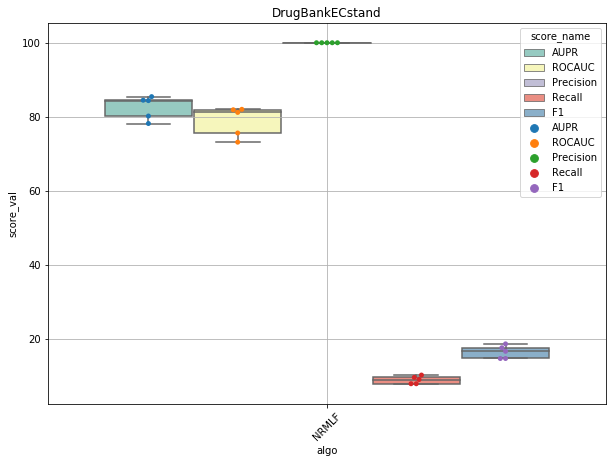

In [17]:
plot_perf_SingleDataset('DrugBankECstand', df_NRMLF, ratio_tr=2, ratio_te=1, setting=1, figsize=(10,7))

# kronSVM
load results of kronSVM method

In [27]:
import os
import pandas as pd
import pickle

list_DB = ['DrugBankHstand', 'DrugBankECstand']

check_list = get_check_list(list_DB)
origin_dir = 'results/pred/'
dico_result = {'dataset':[], 'setting': [], 'ratio_tr': [], 'ratio_te': [], 'algo':[], 
               'score_val': [], 'score_name': [], 'ite': [], 'ival': []}
list_dir_result = [x[0] for x in os.walk(origin_dir)]
del list_dir_result[list_dir_result.index('results/pred/')]
for d in list_dir_result:
    
    # get parameter of exp
    d = d.split('/')[-1]
    special_dataset = False
    for db in TOX21_DATASETS + PCBA_DATASETS:
        if db in d and ',' not in d.split('_')[1]:
            DB = db
            i, setting, ratio_tr, ratio_te = d.split('_')[2:]
            special_dataset = True
            break
    if not special_dataset:
        DB, i, setting, ratio_tr, ratio_te = d.split('_')
        
    if DB in check_list.keys():
        ite, ival = i.split(',')
        ite, ival, setting, ratio_tr, ratio_te = int(ite), int(ival), int(setting), int(ratio_tr), int(ratio_te)
        filename = origin_dir+d+'/handSVM.data'
        if os.path.isfile(filename) and os.path.getsize(filename) > 0:
            check_list = check(check_list, DB, ite, ival, setting, ratio_tr, ratio_te)
            pred, truth, dict_perf = pickle.load(open(filename, 'rb'))
            if DB in LIST_CLF_DATASETS:
                for score_name in ['AUPR', 'ROCAUC', 'Precision', 'Recall', 'F1']:
                    dico_result['dataset'].append(DB)
                    dico_result['setting'].append(setting)
                    dico_result['ratio_tr'].append(ratio_tr)
                    dico_result['ratio_te'].append(ratio_te)
                    dico_result['ite'].append(ite)
                    dico_result['ival'].append(ival)
                    dico_result['algo'].append('feaSVM')
                    #print(DB, score_name, dict_perf[score_name], type(dict_perf[score_name]))
                    if type(dict_perf[score_name]) == tuple:
                        dico_result['score_val'].append(dict_perf[score_name][0])
                    else:
                        dico_result['score_val'].append(dict_perf[score_name])
                    dico_result['score_name'].append(score_name)
            else:
                for score_name in ['MSE']:
                    dico_result['dataset'].append(DB)
                    dico_result['setting'].append(setting)
                    dico_result['ratio_tr'].append(ratio_tr)
                    dico_result['ratio_te'].append(ratio_te)
                    dico_result['ite'].append(ite)
                    dico_result['ival'].append(ival)
                    dico_result['algo'].append('feaSVM')
                    dico_result['score_val'].append(dict_perf[score_name][0])
                    dico_result['score_name'].append(score_name)

print(check_list)
df_feaSVM = pd.DataFrame(dico_result)       

{'DrugBankHstand': [], 'DrugBankECstand': []}


In [28]:
df_feaSVM.head(3)

,dataset,setting,ratio_tr,ratio_te,algo,score_val,score_name,ite,ival
0,DrugBankECstand,4,1,2,feaSVM,46.69,AUPR,0,1
1,DrugBankECstand,4,1,2,feaSVM,60.63,ROCAUC,0,1
2,DrugBankECstand,4,1,2,feaSVM,100.00,Precision,0,1


feaSVM


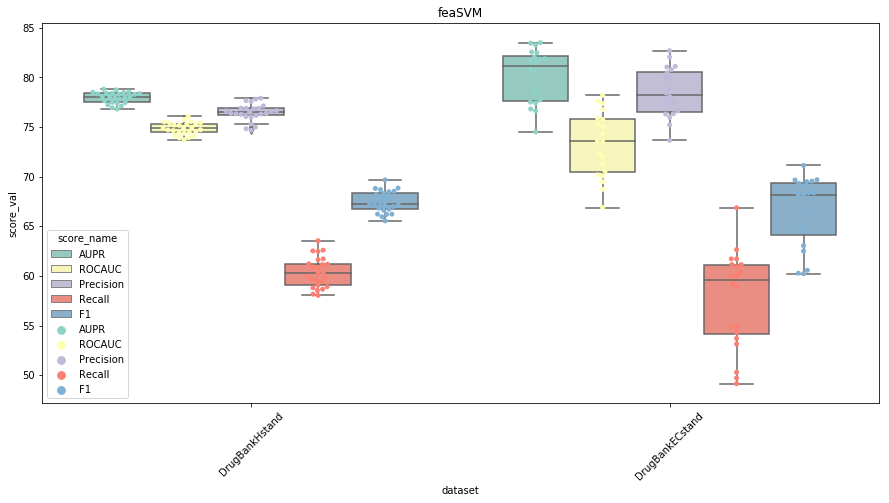

In [29]:
plot_perf_SingleAlgo('feaSVM', df_feaSVM, ratio_tr=1, ratio_te=1, setting=1,
                     list_dataset=['DrugBankHstand', 'DrugBankECstand'], figsize=(15,7))

# FNN results
load results of FNN method

In [30]:
import os
import pandas as pd
import pickle

list_DB = ['DrugBankHstand', 'DrugBankECstand']

origin_dir = 'results/pred/'
dico_result = {'dataset':[], 'setting': [], 'ratio_tr': [], 'ratio_te': [], 'algo':[], 'lr_param': [], 'enc_param': [],
               'score_val': [], 'score_name': [], 'ite': [], 'ival': []}
list_dir_result = [x[0] for x in os.walk(origin_dir)]
del list_dir_result[list_dir_result.index('results/pred/')]
for d in list_dir_result:
    
    # get parameter of exp
    d = d.split('/')[-1]
    special_dataset = False
    for db in TOX21_DATASETS + PCBA_DATASETS:
        if db in d and ',' not in d.split('_')[1]:
            DB = db
            i, setting, ratio_tr, ratio_te = d.split('_')[2:]
            special_dataset = True
            break
    if not special_dataset:
        DB, i, setting, ratio_tr, ratio_te = d.split('_')
        
    if DB in check_list.keys():
        ite, ival = i.split(',')
        ite, ival, setting, ratio_tr, ratio_te = int(ite), int(ival), int(setting), int(ratio_tr), int(ratio_te)
        d=origin_dir+d
        print(d)
        for filename in os.listdir(d):
            if filename[:7] == 'handFNN' and os.path.getsize(d+'/'+filename) > 0:
                paramstr = '_'.join(filename.split('_')[1:])
                param = {}
                for cleval in paramstr.split(';'):
                    list_cleval = cleval.split(':')
                    if list_cleval[0]=='lr_scheduler':
                        param[list_cleval[0]] = ':'.join(list_cleval[1:])
                    else:
                        param[list_cleval[0]] = list_cleval[1]
#BN:True;batch_size:100;drop:0;init_lr:0.001;layers_units:[2000,1000,100];lr_scheduler:{"name":"LearningRateScheduler","rate":0.9};n_epochs:100;patience:20;reg:0.0                    
                print(paramstr,param)
                lr_param = 'bs:'+param['batch_size']+';n:'+param['n_epochs']+';p:'+param['patience']+\
                    ';ilr:'+param['init_lr']+';lrs:'+param['lr_scheduler']
                arch_param = 'l:'+param['layers_units']+';BN:'+param['BN']+';d:'+param['drop']+';r:'+param['reg']
                
                pred, truth, dict_perf = pickle.load(open(d+'/'+filename, 'rb'))
                if DB in LIST_CLF_DATASETS:
                    for score_name in ['AUPR', 'ROCAUC', 'Precision', 'Recall', 'F1']:
                        dico_result['dataset'].append(DB)
                        dico_result['setting'].append(setting)
                        dico_result['ratio_tr'].append(ratio_tr)
                        dico_result['ratio_te'].append(ratio_te)
                        dico_result['ite'].append(ite)
                        dico_result['ival'].append(ival)
                        dico_result['algo'].append('FFN')
                        dico_result['lr_param'].append(lr_param)
                        dico_result['enc_param'].append(arch_param)
                        #print(DB, score_name, dict_perf[score_name], type(dict_perf[score_name]))
                        if type(dict_perf[score_name]) == tuple:
                            dico_result['score_val'].append(dict_perf[score_name][0])
                        else:
                            dico_result['score_val'].append(dict_perf[score_name])
                        dico_result['score_name'].append(score_name)
                else:
                    for score_name in ['MSE']:
                        dico_result['dataset'].append(DB)
                        dico_result['setting'].append(setting)
                        dico_result['ratio_tr'].append(ratio_tr)
                        dico_result['ratio_te'].append(ratio_te)
                        dico_result['ite'].append(ite)
                        dico_result['ival'].append(ival)
                        dico_result['algo'].append('FFN')
                        dico_result['lr_param'].append(lr_param)
                        dico_result['enc_param'].append(arch_param)
                        dico_result['score_val'].append(dict_perf[score_name][0])
                        dico_result['score_name'].append(score_name)

print(check_list)
df_feaFFN = pd.DataFrame(dico_result)       

results/pred/DrugBankHstand_7,6_4_1_5
results/pred/DrugBankECstand_21,4_4_2_1
results/pred/DrugBankHstand_7,7_4_5_2
results/pred/DrugBankHstand_8,14_4_1_1
results/pred/DrugBankHstand_20,7_4_1_2
results/pred/DrugBankHstand_20,3_4_10_2
results/pred/DrugBankECstand_1,3_4_10_5
results/pred/DrugBankHstand_9,7_4_10_2
results/pred/DrugBankECstand_6,9_4_5_2
results/pred/DrugBankECstand_0,1_4_1_2
BN:True;batch_size:100;drop:0.0;init_lr:0.001;layers_units:[2000,1000,100];lr_scheduler:{'name':'LearningRateScheduler','rate':0.9};n_epochs:100;patience:20;reg:0.0.data {'BN': 'True', 'batch_size': '100', 'drop': '0.0', 'init_lr': '0.001', 'layers_units': '[2000,1000,100]', 'lr_scheduler': "{'name':'LearningRateScheduler','rate':0.9}", 'n_epochs': '100', 'patience': '20', 'reg': '0.0.data'}
results/pred/DrugBankHstand_22,10_4_5_1
results/pred/DrugBankHstand_23,1_4_10_5
results/pred/DrugBankECstand_12,15_4_1_5
results/pred/DrugBankHstand_7,9_4_2_5
results/pred/DrugBankECstand_15,6_4_5_5
results/pred/Dr

results/pred/DrugBankECstand_6,11_4_2_2
results/pred/DrugBankHstand_9,0_4_5_2
results/pred/DrugBankHstand_1,3_2_1_2
results/pred/DrugBankECstand_23,9_4_1_5
results/pred/DrugBankHstand_7,5_4_1_5
results/pred/DrugBankECstand_22,3_4_1_1
results/pred/DrugBankHstand_18,11_4_2_5
results/pred/DrugBankHstand_22,15_4_1_1
results/pred/DrugBankHstand_12,5_4_1_2
results/pred/DrugBankECstand_11,4_4_1_2
results/pred/DrugBankHstand_3,6_4_10_5
results/pred/DrugBankECstand_5,3_4_2_10
results/pred/DrugBankECstand_13,9_4_5_1
results/pred/DrugBankECstand_12,2_4_2_1
results/pred/DrugBankECstand_17,15_4_5_2
results/pred/DrugBankHstand_17,3_4_10_1
results/pred/DrugBankECstand_4,3_4_1_1
results/pred/DrugBankHstand_0,1_1_10_10
BN:True;batch_size:100;drop:0.0;init_lr:0.001;layers_units:[2000,1000,100];lr_scheduler:{'name':'LearningRateScheduler','rate':0.9};n_epochs:100;patience:20;reg:0.0.data {'BN': 'True', 'batch_size': '100', 'drop': '0.0', 'init_lr': '0.001', 'layers_units': '[2000,1000,100]', 'lr_schedule

results/pred/DrugBankECstand_19,14_4_5_2
results/pred/DrugBankHstand_13,2_4_1_2
results/pred/DrugBankECstand_16,0_4_5_2
results/pred/DrugBankECstand_14,10_4_10_1
results/pred/DrugBankHstand_16,2_4_10_5
results/pred/DrugBankECstand_4,13_4_10_5
results/pred/DrugBankHstand_6,5_4_1_2
results/pred/DrugBankHstand_4,5_4_5_5
BN:True;batch_size:100;drop:0.0;init_lr:0.001;layers_units:[2000,1000,100];lr_scheduler:{'name':'LearningRateScheduler','rate':0.9};n_epochs:100;patience:20;reg:0.0.data {'BN': 'True', 'batch_size': '100', 'drop': '0.0', 'init_lr': '0.001', 'layers_units': '[2000,1000,100]', 'lr_scheduler': "{'name':'LearningRateScheduler','rate':0.9}", 'n_epochs': '100', 'patience': '20', 'reg': '0.0.data'}
results/pred/DrugBankECstand_17,12_4_1_1
results/pred/DrugBankECstand_8,3_4_10_5
results/pred/DrugBankHstand_16,7_4_10_5
results/pred/DrugBankHstand_8,12_4_5_1
results/pred/DrugBankHstand_1,13_4_5_2
results/pred/DrugBankECstand_23,4_4_5_5
results/pred/DrugBankHstand_2,2_1_1_1
results/p

results/pred/DrugBankECstand_11,13_4_10_2
results/pred/DrugBankHstand_18,10_4_2_2
results/pred/DrugBankECstand_4,1_2_10_5
results/pred/DrugBankHstand_8,6_4_5_1
results/pred/DrugBankHstand_22,1_4_1_1
results/pred/DrugBankECstand_3,1_3_5_1
BN:True;batch_size:100;drop:0.0;init_lr:0.001;layers_units:[2000,1000,100];lr_scheduler:{'name':'LearningRateScheduler','rate':0.9};n_epochs:100;patience:20;reg:0.0.data {'BN': 'True', 'batch_size': '100', 'drop': '0.0', 'init_lr': '0.001', 'layers_units': '[2000,1000,100]', 'lr_scheduler': "{'name':'LearningRateScheduler','rate':0.9}", 'n_epochs': '100', 'patience': '20', 'reg': '0.0.data'}
results/pred/DrugBankHstand_5,11_4_10_1
results/pred/DrugBankHstand_2,8_4_5_2
results/pred/DrugBankECstand_18,0_4_2_1
results/pred/DrugBankHstand_20,12_4_1_2
results/pred/DrugBankHstand_17,1_4_1_2
results/pred/DrugBankECstand_11,3_4_2_5
results/pred/DrugBankECstand_20,12_4_1_2
results/pred/DrugBankHstand_1,7_4_1_1
results/pred/DrugBankECstand_16,12_4_1_2
results/pr

results/pred/DrugBankHstand_8,0_4_1_2
results/pred/DrugBankHstand_3,15_4_10_1
results/pred/DrugBankECstand_15,5_4_5_2
results/pred/DrugBankECstand_6,7_4_5_2
BN:True;batch_size:100;drop:0.0;init_lr:0.001;layers_units:[2000,1000,100];lr_scheduler:{'name':'LearningRateScheduler','rate':0.9};n_epochs:100;patience:20;reg:0.0.data {'BN': 'True', 'batch_size': '100', 'drop': '0.0', 'init_lr': '0.001', 'layers_units': '[2000,1000,100]', 'lr_scheduler': "{'name':'LearningRateScheduler','rate':0.9}", 'n_epochs': '100', 'patience': '20', 'reg': '0.0.data'}
results/pred/DrugBankHstand_2,0_2_5_5
results/pred/DrugBankHstand_5,12_4_1_5
results/pred/DrugBankECstand_2,1_2_10_2
results/pred/DrugBankECstand_0,1_1_2_1
BN:True;batch_size:100;drop:0.0;init_lr:0.001;layers_units:[2000,1000,100];lr_scheduler:{'name':'LearningRateScheduler','rate':0.9};n_epochs:100;patience:20;reg:0.0.data {'BN': 'True', 'batch_size': '100', 'drop': '0.0', 'init_lr': '0.001', 'layers_units': '[2000,1000,100]', 'lr_scheduler': 

results/pred/DrugBankECstand_10,2_4_10_5
results/pred/DrugBankECstand_0,3_1_1_5
BN:True;batch_size:100;drop:0.0;init_lr:0.001;layers_units:[2000,1000,100];lr_scheduler:{'name':'LearningRateScheduler','rate':0.9};n_epochs:100;patience:20;reg:0.0.data {'BN': 'True', 'batch_size': '100', 'drop': '0.0', 'init_lr': '0.001', 'layers_units': '[2000,1000,100]', 'lr_scheduler': "{'name':'LearningRateScheduler','rate':0.9}", 'n_epochs': '100', 'patience': '20', 'reg': '0.0.data'}
results/pred/DrugBankHstand_12,3_4_10_2
results/pred/DrugBankECstand_13,8_4_10_2
results/pred/DrugBankECstand_0,2_4_5_2
results/pred/DrugBankECstand_7,1_4_10_2
results/pred/DrugBankECstand_13,6_4_1_1
results/pred/DrugBankECstand_22,3_4_5_5
results/pred/DrugBankECstand_9,9_4_5_5
results/pred/DrugBankECstand_20,14_4_2_1
results/pred/DrugBankECstand_22,4_4_1_2
results/pred/DrugBankHstand_18,0_4_10_1
results/pred/DrugBankECstand_21,13_4_10_10
results/pred/DrugBankECstand_8,11_4_2_1
results/pred/DrugBankHstand_13,8_4_5_5
res

results/pred/DrugBankECstand_14,15_4_2_10
results/pred/DrugBankECstand_1,14_4_2_1
results/pred/DrugBankECstand_19,5_4_2_1
results/pred/DrugBankHstand_3,9_4_10_1
results/pred/DrugBankHstand_3,6_4_1_2
results/pred/DrugBankECstand_4,1_3_1_10
results/pred/DrugBankHstand_10,3_4_2_5
results/pred/DrugBankHstand_0,4_1_1_2
results/pred/DrugBankHstand_15,12_4_2_5
results/pred/DrugBankECstand_16,15_4_5_5
results/pred/DrugBankECstand_15,12_4_10_10
results/pred/DrugBankHstand_21,13_4_10_5
results/pred/DrugBankHstand_15,2_4_1_1
results/pred/DrugBankHstand_24,0_4_1_1
results/pred/DrugBankHstand_1,1_4_10_5
results/pred/DrugBankECstand_21,3_4_2_1
results/pred/DrugBankECstand_9,0_4_10_1
results/pred/DrugBankHstand_7,8_4_1_1
BN:True;batch_size:100;drop:0.0;init_lr:0.001;layers_units:[2000,1000,100];lr_scheduler:{'name':'LearningRateScheduler','rate':0.9};n_epochs:100;patience:20;reg:0.0.data {'BN': 'True', 'batch_size': '100', 'drop': '0.0', 'init_lr': '0.001', 'layers_units': '[2000,1000,100]', 'lr_sche

results/pred/DrugBankECstand_17,9_4_1_5
results/pred/DrugBankHstand_12,8_4_2_2
results/pred/DrugBankECstand_23,7_4_5_1
results/pred/DrugBankHstand_2,15_4_2_2
results/pred/DrugBankECstand_1,3_2_1_2
BN:True;batch_size:100;drop:0.0;init_lr:0.001;layers_units:[2000,1000,100];lr_scheduler:{'name':'LearningRateScheduler','rate':0.9};n_epochs:100;patience:20;reg:0.0.data {'BN': 'True', 'batch_size': '100', 'drop': '0.0', 'init_lr': '0.001', 'layers_units': '[2000,1000,100]', 'lr_scheduler': "{'name':'LearningRateScheduler','rate':0.9}", 'n_epochs': '100', 'patience': '20', 'reg': '0.0.data'}
results/pred/DrugBankHstand_10,12_4_5_2
results/pred/DrugBankHstand_2,3_2_5_10
results/pred/DrugBankHstand_0,14_4_2_1
results/pred/DrugBankHstand_8,4_4_1_2
results/pred/DrugBankECstand_9,6_4_1_2
results/pred/DrugBankHstand_16,2_4_5_2
results/pred/DrugBankHstand_11,4_4_1_1
results/pred/DrugBankHstand_9,12_4_1_2
results/pred/DrugBankHstand_24,3_4_10_1
results/pred/DrugBankECstand_23,14_4_10_1
results/pred/D

results/pred/DrugBankHstand_4,5_4_2_2
BN:True;batch_size:100;drop:0.0;init_lr:0.001;layers_units:[2000,1000,100];lr_scheduler:{'name':'LearningRateScheduler','rate':0.9};n_epochs:100;patience:20;reg:0.0.data {'BN': 'True', 'batch_size': '100', 'drop': '0.0', 'init_lr': '0.001', 'layers_units': '[2000,1000,100]', 'lr_scheduler': "{'name':'LearningRateScheduler','rate':0.9}", 'n_epochs': '100', 'patience': '20', 'reg': '0.0.data'}
results/pred/DrugBankHstand_8,9_4_1_2
BN:True;batch_size:100;drop:0.0;init_lr:0.001;layers_units:[2000,1000,100];lr_scheduler:{'name':'LearningRateScheduler','rate':0.9};n_epochs:100;patience:20;reg:0.0.data {'BN': 'True', 'batch_size': '100', 'drop': '0.0', 'init_lr': '0.001', 'layers_units': '[2000,1000,100]', 'lr_scheduler': "{'name':'LearningRateScheduler','rate':0.9}", 'n_epochs': '100', 'patience': '20', 'reg': '0.0.data'}
results/pred/DrugBankECstand_11,8_4_10_10
results/pred/DrugBankECstand_22,10_4_2_5
results/pred/DrugBankECstand_14,9_4_10_1
results/pr

results/pred/DrugBankECstand_1,1_4_10_10
results/pred/DrugBankHstand_19,1_4_5_5
results/pred/DrugBankHstand_2,11_4_2_2
results/pred/DrugBankECstand_5,15_4_10_2
results/pred/DrugBankECstand_19,8_4_1_1
results/pred/DrugBankECstand_15,1_4_10_1
results/pred/DrugBankHstand_24,2_4_5_5
results/pred/DrugBankECstand_16,3_4_1_5
results/pred/DrugBankECstand_13,3_4_10_2
results/pred/DrugBankHstand_14,4_4_1_1
results/pred/DrugBankHstand_2,10_4_5_2
results/pred/DrugBankECstand_18,4_4_10_2
results/pred/DrugBankHstand_12,6_4_2_5
results/pred/DrugBankECstand_5,14_4_10_2
results/pred/DrugBankHstand_15,7_4_1_5
results/pred/DrugBankHstand_2,3_3_5_5
BN:True;batch_size:100;drop:0.0;init_lr:0.001;layers_units:[2000,1000,100];lr_scheduler:{'name':'LearningRateScheduler','rate':0.9};n_epochs:100;patience:20;reg:0.0.data {'BN': 'True', 'batch_size': '100', 'drop': '0.0', 'init_lr': '0.001', 'layers_units': '[2000,1000,100]', 'lr_scheduler': "{'name':'LearningRateScheduler','rate':0.9}", 'n_epochs': '100', 'pati

results/pred/DrugBankHstand_21,9_4_2_5
results/pred/DrugBankHstand_1,2_1_10_1
results/pred/DrugBankECstand_11,13_4_5_5
results/pred/DrugBankHstand_19,11_4_2_1
results/pred/DrugBankHstand_2,0_1_5_2
results/pred/DrugBankECstand_3,10_4_1_1
results/pred/DrugBankECstand_12,12_4_5_1
results/pred/DrugBankHstand_21,8_4_10_2
results/pred/DrugBankHstand_15,6_4_2_1
results/pred/DrugBankECstand_16,13_4_10_1
results/pred/DrugBankHstand_14,13_4_1_1
results/pred/DrugBankHstand_23,0_4_2_5
results/pred/DrugBankHstand_3,3_4_10_1
results/pred/DrugBankHstand_15,9_4_10_5
results/pred/DrugBankECstand_12,5_4_2_5
results/pred/DrugBankECstand_11,15_4_2_5
results/pred/DrugBankECstand_0,1_2_1_5
BN:True;batch_size:100;drop:0.0;init_lr:0.001;layers_units:[2000,1000,100];lr_scheduler:{'name':'LearningRateScheduler','rate':0.9};n_epochs:100;patience:20;reg:0.0.data {'BN': 'True', 'batch_size': '100', 'drop': '0.0', 'init_lr': '0.001', 'layers_units': '[2000,1000,100]', 'lr_scheduler': "{'name':'LearningRateScheduler

results/pred/DrugBankECstand_13,5_4_1_5
results/pred/DrugBankHstand_12,15_4_2_2
results/pred/DrugBankECstand_3,8_4_1_5
results/pred/DrugBankHstand_20,3_4_2_5
results/pred/DrugBankHstand_6,13_4_10_10
results/pred/DrugBankHstand_11,14_4_10_2
results/pred/DrugBankECstand_1,0_4_2_10
results/pred/DrugBankHstand_4,3_3_5_1
results/pred/DrugBankECstand_12,2_4_2_5
results/pred/DrugBankECstand_17,6_4_1_5
results/pred/DrugBankECstand_20,11_4_2_2
results/pred/DrugBankHstand_12,7_4_10_10
results/pred/DrugBankECstand_10,14_4_5_2
results/pred/DrugBankECstand_18,14_4_1_1
results/pred/DrugBankECstand_7,1_4_5_5
results/pred/DrugBankECstand_1,3_2_2_2
BN:True;batch_size:100;drop:0.0;init_lr:0.001;layers_units:[2000,1000,100];lr_scheduler:{'name':'LearningRateScheduler','rate':0.9};n_epochs:100;patience:20;reg:0.0.data {'BN': 'True', 'batch_size': '100', 'drop': '0.0', 'init_lr': '0.001', 'layers_units': '[2000,1000,100]', 'lr_scheduler': "{'name':'LearningRateScheduler','rate':0.9}", 'n_epochs': '100', 'p

results/pred/DrugBankECstand_3,2_2_2_1
BN:True;batch_size:100;drop:0.0;init_lr:0.001;layers_units:[2000,1000,100];lr_scheduler:{'name':'LearningRateScheduler','rate':0.9};n_epochs:100;patience:20;reg:0.0.data {'BN': 'True', 'batch_size': '100', 'drop': '0.0', 'init_lr': '0.001', 'layers_units': '[2000,1000,100]', 'lr_scheduler': "{'name':'LearningRateScheduler','rate':0.9}", 'n_epochs': '100', 'patience': '20', 'reg': '0.0.data'}
results/pred/DrugBankHstand_16,1_4_1_10
results/pred/DrugBankHstand_24,12_4_2_1
results/pred/DrugBankHstand_1,3_1_5_1
results/pred/DrugBankECstand_10,3_4_1_2
results/pred/DrugBankHstand_16,8_4_5_1
results/pred/DrugBankHstand_24,1_4_5_1
results/pred/DrugBankHstand_6,4_4_10_2
results/pred/DrugBankECstand_3,2_3_1_5
BN:True;batch_size:100;drop:0.0;init_lr:0.001;layers_units:[2000,1000,100];lr_scheduler:{'name':'LearningRateScheduler','rate':0.9};n_epochs:100;patience:20;reg:0.0.data {'BN': 'True', 'batch_size': '100', 'drop': '0.0', 'init_lr': '0.001', 'layers_uni

results/pred/DrugBankECstand_20,10_4_10_5
results/pred/DrugBankHstand_10,9_4_1_1
results/pred/DrugBankECstand_20,5_4_5_10
results/pred/DrugBankHstand_19,11_4_1_5
results/pred/DrugBankECstand_12,13_4_2_5
BN:True;batch_size:100;drop:0.0;init_lr:0.001;layers_units:[2000,1000,100];lr_scheduler:{'name':'LearningRateScheduler','rate':0.9};n_epochs:100;patience:20;reg:0.0.data {'BN': 'True', 'batch_size': '100', 'drop': '0.0', 'init_lr': '0.001', 'layers_units': '[2000,1000,100]', 'lr_scheduler': "{'name':'LearningRateScheduler','rate':0.9}", 'n_epochs': '100', 'patience': '20', 'reg': '0.0.data'}
results/pred/DrugBankECstand_3,7_4_1_2
results/pred/DrugBankECstand_11,2_4_10_1
results/pred/DrugBankECstand_19,7_4_10_1
results/pred/DrugBankHstand_24,8_4_5_1
results/pred/DrugBankHstand_9,6_4_2_5
results/pred/DrugBankHstand_17,11_4_5_2
results/pred/DrugBankHstand_14,11_4_5_2
results/pred/DrugBankECstand_6,11_4_2_1
results/pred/DrugBankECstand_15,6_4_1_1
results/pred/DrugBankHstand_18,1_4_2_2
resul

BN:True;batch_size:100;drop:0.0;init_lr:0.001;layers_units:[2000,1000,100];lr_scheduler:{'name':'LearningRateScheduler','rate':0.9};n_epochs:100;patience:20;reg:0.0.data {'BN': 'True', 'batch_size': '100', 'drop': '0.0', 'init_lr': '0.001', 'layers_units': '[2000,1000,100]', 'lr_scheduler': "{'name':'LearningRateScheduler','rate':0.9}", 'n_epochs': '100', 'patience': '20', 'reg': '0.0.data'}
results/pred/DrugBankHstand_19,1_4_1_5
results/pred/DrugBankECstand_18,1_4_1_1
results/pred/DrugBankECstand_2,1_4_10_10
results/pred/DrugBankHstand_4,1_3_2_5
results/pred/DrugBankHstand_17,13_4_1_2
results/pred/DrugBankHstand_11,0_4_2_2
results/pred/DrugBankHstand_18,1_4_2_1
results/pred/DrugBankHstand_18,12_4_1_2
results/pred/DrugBankECstand_4,8_4_10_1
results/pred/DrugBankECstand_10,10_4_1_2
results/pred/DrugBankECstand_24,13_4_10_5
results/pred/DrugBankECstand_0,7_4_1_2
results/pred/DrugBankHstand_10,1_4_10_10
results/pred/DrugBankECstand_0,15_4_2_1
results/pred/DrugBankHstand_13,11_4_2_5
result

BN:True;batch_size:100;drop:0.0;init_lr:0.001;layers_units:[2000,1000,100];lr_scheduler:{'name':'LearningRateScheduler','rate':0.9};n_epochs:100;patience:20;reg:0.0.data {'BN': 'True', 'batch_size': '100', 'drop': '0.0', 'init_lr': '0.001', 'layers_units': '[2000,1000,100]', 'lr_scheduler': "{'name':'LearningRateScheduler','rate':0.9}", 'n_epochs': '100', 'patience': '20', 'reg': '0.0.data'}
results/pred/DrugBankECstand_10,11_4_5_5
BN:True;batch_size:100;drop:0.0;init_lr:0.001;layers_units:[2000,1000,100];lr_scheduler:{'name':'LearningRateScheduler','rate':0.9};n_epochs:100;patience:20;reg:0.0.data {'BN': 'True', 'batch_size': '100', 'drop': '0.0', 'init_lr': '0.001', 'layers_units': '[2000,1000,100]', 'lr_scheduler': "{'name':'LearningRateScheduler','rate':0.9}", 'n_epochs': '100', 'patience': '20', 'reg': '0.0.data'}
results/pred/DrugBankECstand_11,14_4_5_1
results/pred/DrugBankHstand_20,6_4_5_1
results/pred/DrugBankHstand_8,14_4_10_2
results/pred/DrugBankECstand_1,11_4_1_2
results/p

In [31]:
df_feaFFN.head(5)

,dataset,setting,ratio_tr,ratio_te,algo,lr_param,enc_param,score_val,score_name,ite,ival
0,DrugBankECstand,4,1,2,FFN,bs:100;n:100;p:20;ilr:0.001;lrs:{'name':'Learn...,"l:[2000,1000,100];BN:True;d:0.0;r:0.0.data",34.16,AUPR,0,1
1,DrugBankECstand,4,1,2,FFN,bs:100;n:100;p:20;ilr:0.001;lrs:{'name':'Learn...,"l:[2000,1000,100];BN:True;d:0.0;r:0.0.data",47.70,ROCAUC,0,1
2,DrugBankECstand,4,1,2,FFN,bs:100;n:100;p:20;ilr:0.001;lrs:{'name':'Learn...,"l:[2000,1000,100];BN:True;d:0.0;r:0.0.data",33.87,Precision,0,1
3,DrugBankECstand,4,1,2,FFN,bs:100;n:100;p:20;ilr:0.001;lrs:{'name':'Learn...,"l:[2000,1000,100];BN:True;d:0.0;r:0.0.data",43.75,Recall,0,1
4,DrugBankECstand,4,1,2,FFN,bs:100;n:100;p:20;ilr:0.001;lrs:{'name':'Learn...,"l:[2000,1000,100];BN:True;d:0.0;r:0.0.data",38.18,F1,0,1


# CN results
load results of chemonegenomic neuron network

In [32]:
def str_param_from_dict(DB, dict_param):
    learning_param, enc_param, pred_param = '', '', ''
    for param in ['bs', 'ne', 'lrs', 'lri']:
        learning_param += param+':'+dict_param[param]+';'
    if 'repeat' in dict_param.keys() and dict_param['repeat'] != 1:
        learning_param = str(dict_param['repeat']) + '_' + learning_param
    for param in ['prl', 'prd', 'prr', 'pred_BN']:
        pred_param += param+':'+dict_param[param]+';'
    if DB in LIST_PROT_DATASETS + LIST_AA_DATASETS:
        dict_param['pcurr'] = dict_param['curriculum']
        for param in ['slen', 'pcurr', 'penc', 'pB', 'pd', 'pr']:
            enc_param+=param+':'+dict_param[param]+';'
    if DB in LIST_MOL_DATASETS:
        dict_param['mcurr'] = dict_param['curriculum']
        for param in ['mcurr', 'nconv', 'aggn', 'agga', 'comb', 'mB', 'md', 'mr']:
            enc_param+=param+':'+dict_param[param]+';'
    if DB in LIST_DTI_DATASETS:
        for param in ['j', 'slen', 'pcurr', 'penc', 'mcurr', 'nconv', 
                      'aggn', 'agga', 'comb', 
                      'pB', 'pd', 'pr', 'mB', 'md', 'mr']:
            enc_param+=param+':'+dict_param[param]+';'
    return learning_param.replace('"', "'"), enc_param.replace('"', "'"), pred_param.replace('"', "'")

def get_params_from_modelstr(DB, strmodel):
    dict_param = {}
    
    if strmodel[0] in ['1', '2', '3', '4', '5']:
        dict_param['repeat'] = int(strmodel[0])
        strmodel = '_'.join(strmodel.split('_')[1:])
    else:
        dict_param['repeat'] = 1
    model_list = strmodel.split(';')
    
    for el in model_list:
        el = el.split(':')
        if len(el) > 2:
            param, val = el[0], ":".join(el[1:])
        else:
            param, val = el
        if param == 'p_curriculum':
            param = 'pcurr'
        if param == 'm_curriculum':
            param = 'mcurr'
        if param == 'seq_length':
            param = 'slen'
        if param == 'jointer':
            param = 'j'
        if param == 'prot_encoder':
            param = 'penc'
        if param == 'm_curriculum':
            param = 'mcurr'
        if param == 'combine':
            param = 'comb'
        dict_param[param] = val
    
    learning_param, enc_param, pred_param = str_param_from_dict(DB, dict_param)
    # bs:1;ne:50;lri:0.001;pa:5;lrs:{'name':'LearningRateScheduler','rate':0.8};
    #prl:[100];pred_BN:False;prd:0.0;prr:0.0;seq_length:None;p_curriculum:None;
    #prot_encoder:{'name':'conv','n_steps':2,'nb_conv_filters':100,'filter_size':12,'conv_strides':3,'hand_crafted_features':0};
    #pB:False;pd:0.0;pr:0.0;m_curriculum:None;nconv:3;aggn:{'name':'standard','n_filters':50,'n_heads':5};
    #agga:{'name':'sum'};combine:{'name':'sum','hand_crafted_features':0};
    #mB:False;md:0.0;mr:0.0;jointer:{'name':'concat','hand_crafted_features':0,'reg':0}
    return learning_param, enc_param, pred_param

In [33]:
import os
import pandas as pd
import pickle

list_DB = ['DrugBankH', 'DrugBankEC', 'DrugBankHstand', 'DrugBankECstand', 'DrugBankHEC-ECstand', 'CellLoc', 'SCOPe'] + \
    TOX21_DATASETS + LIST_REGR_DATASETS + ['Tox21', 'HIV', 'PCBA', 'MembranePermeability', 'AtomizationEnergy']

check_list = get_check_list(list_DB)
print(len(check_list['DrugBankH']))
origin_dir = 'results/perf/'
dico_result = {'dataset':[], 'setting': [], 'ratio_tr': [], 'ratio_te': [], 'algo':[], 
               'lr_param': [], 'enc_param': [], 'pred_param': [], 'ite': [], 'ival': [],
               'score_val': [], 'score_name': []}
list_dir_result = [x[0] for x in os.walk(origin_dir)]
del list_dir_result[list_dir_result.index('results/perf/')]
for d in list_dir_result:
    # get parameter of exp
    d = d.split('/')[-1]
    special_dataset = False
    for db in TOX21_DATASETS + PCBA_DATASETS:
        if db in d and ',' not in d.split('_')[1]:
            DB = db
            i, setting, ratio_tr, ratio_te = d.split('_')[2:]
            special_dataset = True
            break
    if not special_dataset:
        DB, i, setting, ratio_tr, ratio_te = d.split('_')
    #print(DB)
    if DB not in check_list.keys():
        print("############# DB ###############")
    if setting == 4:
        print(d)
    if DB in check_list.keys():
        ite, ival = i.split(',')
        ite, ival, setting, ratio_tr, ratio_te = int(ite), int(ival), int(setting), int(ratio_tr), int(ratio_te)
        
        d='results/perf/'+d
        #print(d)
        
        for filename in os.listdir(d):
            print(filename)
            if filename[:2] == 'NN' and 'all' not in filename and os.path.getsize(d+'/'+filename) > 0:
                # get parameter of model
                strmodel, dict_perf = pickle.load(open(d+'/'+filename, 'rb'))
                #print(strmodel)
                learning_param, enc_param, pred_param = get_params_from_modelstr(DB, strmodel)
        
                check_list = check(check_list, DB, ite, ival, setting, ratio_tr, ratio_te)
                if DB in LIST_CLF_DATASETS:
                    for score_name in ['AUPR', 'ROCAUC', 'Precision', 'Recall', 'F1']:
                        dico_result['dataset'].append(DB)
                        dico_result['setting'].append(setting)
                        dico_result['ratio_tr'].append(ratio_tr)
                        dico_result['ratio_te'].append(ratio_te)
                        dico_result['ite'].append(ite)
                        dico_result['ival'].append(ival)
                        dico_result['algo'].append('NN')
                        dico_result['lr_param'].append(learning_param)
                        dico_result['enc_param'].append(enc_param)
                        dico_result['pred_param'].append(pred_param)
                        #print(DB, score_name, dict_perf[score_name], type(dict_perf[score_name]))
                        if type(dict_perf[score_name]) == tuple:
                            dico_result['score_val'].append(dict_perf[score_name][0])
                        else:
                            dico_result['score_val'].append(dict_perf[score_name])
                        dico_result['score_name'].append(score_name)
                else:
                    for score_name in ['MSE']:
                        dico_result['dataset'].append(DB)
                        dico_result['setting'].append(setting)
                        dico_result['ratio_tr'].append(ratio_tr)
                        dico_result['ratio_te'].append(ratio_te)
                        dico_result['ite'].append(ite)
                        dico_result['ival'].append(ival)
                        dico_result['algo'].append('NN')
                        dico_result['lr_param'].append(learning_param)
                        dico_result['enc_param'].append(enc_param)
                        dico_result['pred_param'].append(pred_param)
                        dico_result['score_val'].append(dict_perf[score_name][0])
                        dico_result['score_name'].append(score_name)

print(check_list)
df_NN = pd.DataFrame(dico_result)       

67
NN_dn0z_5tv.data
NN_ufggp3wd.data
NN_tfgupbgl.data
NN_1bimmd18.data
NN_ut__bfhv.data
NN_e9ib99bx.data
NN_st0jo30g.data
NN_oaiuvgu5.data
NN_b_rzkp59.data
NN_j_297dro.data
NN_9yn_of42.data
NN_amu4m6cx.data
NN_eucpunou.data
NN_b8knorgk.data
NN_vu8x0wdn.data
NN_hw_4gui6.data
NN_scf6pch4.data
NN_w30duna4.data
NN_od_udzp8.data
NN_7erf1qus.data
NN_owr5_6y6.data
NN_c6yeh_vl.data
NN_utpn6c99.data
NN_ix2289vh.data
NN_k0gyot22.data
NN_h0npe67j.data
NN_67x8ympc.data
NN_hok_a0n4.data
NN_pu7hbkk3.data
NN_j5zox736.data
NN_vcghsly5.data
NN_mn_pnr95.data
NN_f06hqrpc.data
NN_8jvnf5j0.data
NN_xg1h21ud.data
NN_2w62lbef.data
NN_edo5qh85.data
NN_blw870h6.data
NN_y32jktwv.data
NN_pftfmkq7.data
NN_0suat13j.data
NN_0ihqmz6l.data
NN_lu5ydgff.data
NN_wyptmpt4.data
NN_zkk4g2co.data
NN_smionz2y.data
NN_t_gblmwu.data
NN_u70xcsjy.data
NN_9ym7gbya.data
NN_v3do_l8n.data
NN_c0z_xphr.data
NN_vo2dqk_x.data
NN_n7sosqez.data
NN_wxtjsn33.data
NN_8vk0dx0s.data
NN_e8td99z0.data
NN_yu69q1el.data
NN_h97djnvu.data
NN_0m39erla

NN_ljnva966.data
NN_1mcylgsg.data
NN_fgi0mgjb.data
NN_dr2hv256.data
NN_1mvanyxn.data
NN_k20tdh_l.data
NN_6cf2oe9s.data
NN_my54ysz2.data
NN_buzvz4r_.data
NN_ds8i52rm.data
NN_4us37gi5.data
NN_f2prt8qw.data
NN_cfmrc5fc.data
NN_j6gsmqca.data
NN_mao0ysff.data
NN_9d3khczd.data
NN__vv5k36h.data
NN_tygpysbq.data
NN_qxuuijtp.data
NN_58y1utss.data
NN_jd1kaupk.data
NN_7_mi3f9q.data
NN_l489302d.data
NN_kg2vixwn.data
NN_90b8gk78.data
NN_io9a0t7a.data
NN_sa47dj5d.data
NN_jp300qj8.data
NN_9pguz2w1.data
NN_qd1xbspu.data
NN_16p39vzs.data
NN_dhygqtwu.data
NN_jr7kv3oi.data
NN_ecj4ucu5.data
NN_072sxunj.data
NN_6f2o3ecx.data
NN_yuzkvr6g.data
NN_6f137i0e.data
NN_8u4wawdb.data
NN_blf79ehk.data
NN_j_kncjvr.data
NN_8qucc15c.data
NN_fetu6s8k.data
NN_nm2wik2u.data
NN_p4ir_tu9.data
NN_lhm3gth1.data
NN_83lkcnr0.data
NN_jyzlx7u7.data
NN__la_7p3y.data
NN_3jpryjju.data
NN_iw1sokg7.data
NN_3u5al1hl.data
NN_esref961.data
NN_kxm3ofg1.data
NN_8ko6ebgk.data
NN_6uekyx6u.data
NN_3ovo6l2m.data
NN_ppgk414g.data
NN_zp_9nr94.da

2NN__madegw6_all.data
2NN_cqizdly5_all.data
2NN_7dcdd7qf_all.data
2NN_ii0_uc0r_all.data
2NN_8g_ikcxy_all.data
2NN_ms2xfnch_all.data
2NN_3epil_sc_all.data
2NN_8exuranp_all.data
2NN_cw6xzg0i_all.data
2NN_eanibpao_all.data
2NN_na23x9ni_all.data
2NN_zh0jy_um_all.data
2NN_xokmgxgu_all.data
2NN_lzqxfta4_all.data
2NN_kz1p4o42_all.data
2NN_nvfc28ju_all.data
2NN_1znnno_9_all.data
2NN_k1qx4row_all.data
2NN_a86myd7d_all.data
2NN_xw3a8tin_all.data
2NN_cm6q57fn_all.data
2NN_zan1sdh8_all.data
2NN_n8r4kkbe_all.data
2NN_5qiho9dt_all.data
2NN_s_8sgy0b_all.data
2NN_4nhi_ov3_all.data
2NN_pygk13xz_all.data
2NN_keoczbk1_all.data
2NN_lxkl00xv_all.data
2NN_u9qgldx9_all.data
NN_mksp348z.data
2NN_f3cw41lr_all.data
2NN_i0n693pc_all.data
2NN_epw1q2jr_all.data
2NN_4jn7j7mc_all.data
2NN_wpm83niy_all.data
2NN_hytht38y_all.data
2NN_orklb2le_all.data
2NN_7zer_9fp_all.data
2NN_cnsonl3m_all.data
2NN_zvkzeqjo_all.data
2NN_k1_4851l_all.data
2NN_4dxzg0l2_all.data
2NN_1ur7yof3_all.data
2NN_5q0v569u_all.data
2NN_7hbomx6g_al

NN_6yp7ifcs.data
NN_lif6vcp2.data
NN_yyv5gsg_.data
NN_edbrmfli.data
NN_5xz_o4mw.data
NN_vdimxkfo.data
NN_6h0vfc12.data
NN__yqa75o0.data
NN_impiobcc.data
NN_zqp0ol_7.data
NN_uf89r_qf.data
NN_1_blrsqr.data
NN__tf3mcuw.data
NN_gzk4tmzt.data
NN_8fy00t7x.data
NN_cfpp3bts.data
NN_kgktdb7_.data
NN_9ad366g8.data
NN__ldgck9a.data
NN_iyquqfxp.data
NN_2s9hr966.data
NN_1wypa5ft.data
NN_03y1npda.data
NN_eokx7n52.data
NN_1yy0iuo5.data
NN_tozg3a2j.data
NN_iix99ry1.data
NN_4tcic5lq.data
NN_c4jeubvt.data
NN_ic7fq_0a.data
NN_eh0zfqbf.data
NN_8l8gh1w8.data
NN_y3kzn0_g.data
NN_66buckiq.data
NN_8uxnksvo.data
NN_vsqe38yc.data
NN_m9v3eood.data
NN_9zac390x.data
NN__mt9x1a1.data
NN_i5rp6qq6.data
NN_xvfnvfln.data
NN_ol8h8u5j.data
NN_u9okj6jh.data
NN_d3b5fkdn.data
NN_bybqovh8.data
NN_6bhtcvc0.data
NN_gx23bkz1.data
NN_4c1qtwrf.data
NN_cazbjdgt.data
NN_0ia33ap2.data
NN_g1353zoc.data
NN_a8b5em4k.data
NN_zdjclija.data
NN_4ym8pr1o.data
NN_gge3igtk.data
NN_idkkjg1e.data
NN_gy3s8e06.data
NN_b2y5g5ri.data
NN_lgk17mqq.da

In [34]:
df_NNdti = df_NN[df_NN.dataset.isin(LIST_DTI_DATASETS)]

# DrugBank E.Coli
process the dataframes

In [35]:
DBECs_dfdti_best = df_NNdti.copy()
lr_param = "3_bs:20;ne:100;lrs:{'name':'LearningRateScheduler','rate':0.9};lri:0.001;"
pred_param = 'prl:[100];prd:0.0;prr:0.0;pred_BN:True;'
DBECs_dfdti_best = DBECs_dfdti_best[DBECs_dfdti_best['lr_param']==lr_param]
DBECs_dfdti_best = DBECs_dfdti_best[DBECs_dfdti_best['pred_param']==pred_param]
#enc_param = "j:{'name':'concat','hand_crafted_features':0,'reg':0};slen:None;pcurr:None;penc:{'name':'conv','n_steps':2,'nb_conv_filters':100,'filter_size':12,'conv_strides':3,'hand_crafted_features':0};mcurr:None;nconv:3;aggn:{'name':'standard','n_filters':50,'n_heads':5};agga:{'name':'sum'};comb:{'name':'sum','hand_crafted_features':0};"
enc_param = "'n_steps':3,'nb_conv_filters':100,'filter_size':8,'conv_strides':3,'hand_crafted_features':0}"+\
    ";mcurr:None;nconv:3;aggn:{'name':'standard','n_filters':100,'n_heads':5};"+\
    "agga:{'name':'sum','pool_name':'standard','reg':0,'drop':0,'n_atoms':0};"+\
    "comb:{'name':'sum','hand_crafted_features':0};pB:True;pd:0.0;pr:0.0;mB:True;md:0.0;mr:0.0;"
DBECs_dfdti_best = DBECs_dfdti_best[DBECs_dfdti_best['enc_param'].str.contains(enc_param)]
enc_param = "j:{'name':'concat','hand_crafted_features':0,'reg':0}"
DBECs_dfdti_best = DBECs_dfdti_best[DBECs_dfdti_best['enc_param'].str.contains(enc_param)]
DBECs_dfdti_best = DBECs_dfdti_best[DBECs_dfdti_best.score_name.isin(['ROCAUC', 'AUPR'])]

In [36]:
## restrict to ratio_tr < 5
DBECs_dfdti_best = DBECs_dfdti_best[DBECs_dfdti_best.ratio_tr.isin([1,2,5])]

In [37]:
DBECs_dfdti_best[(DBECs_dfdti_best["setting"]==2) & (DBECs_dfdti_best["ratio_tr"]==2) & (DBECs_dfdti_best["ratio_te"]==2)]

,dataset,setting,ratio_tr,ratio_te,algo,lr_param,enc_param,pred_param,ite,ival,score_val,score_name
2955,DrugBankECstand,2,2,2,NN,3_bs:20;ne:100;lrs:{'name':'LearningRateSchedu...,"j:{'name':'concat','hand_crafted_features':0,'...",prl:[100];prd:0.0;prr:0.0;pred_BN:True;,2,3,43.39,AUPR
2956,DrugBankECstand,2,2,2,NN,3_bs:20;ne:100;lrs:{'name':'LearningRateSchedu...,"j:{'name':'concat','hand_crafted_features':0,'...",prl:[100];prd:0.0;prr:0.0;pred_BN:True;,2,3,59.71,ROCAUC
3220,DrugBankECstand,2,2,2,NN,3_bs:20;ne:100;lrs:{'name':'LearningRateSchedu...,"j:{'name':'concat','hand_crafted_features':0,'...",prl:[100];prd:0.0;prr:0.0;pred_BN:True;,3,4,35.23,AUPR
3221,DrugBankECstand,2,2,2,NN,3_bs:20;ne:100;lrs:{'name':'LearningRateSchedu...,"j:{'name':'concat','hand_crafted_features':0,'...",prl:[100];prd:0.0;prr:0.0;pred_BN:True;,3,4,51.84,ROCAUC
8017,DrugBankECstand,2,2,2,NN,3_bs:20;ne:100;lrs:{'name':'LearningRateSchedu...,"j:{'name':'concat','hand_crafted_features':0,'...",prl:[100];prd:0.0;prr:0.0;pred_BN:True;,4,0,48.02,AUPR
8018,DrugBankECstand,2,2,2,NN,3_bs:20;ne:100;lrs:{'name':'LearningRateSchedu...,"j:{'name':'concat','hand_crafted_features':0,'...",prl:[100];prd:0.0;prr:0.0;pred_BN:True;,4,0,68.11,ROCAUC
8707,DrugBankECstand,2,2,2,NN,3_bs:20;ne:100;lrs:{'name':'LearningRateSchedu...,"j:{'name':'concat','hand_crafted_features':0,'...",prl:[100];prd:0.0;prr:0.0;pred_BN:True;,0,1,46.24,AUPR
8708,DrugBankECstand,2,2,2,NN,3_bs:20;ne:100;lrs:{'name':'LearningRateSchedu...,"j:{'name':'concat','hand_crafted_features':0,'...",prl:[100];prd:0.0;prr:0.0;pred_BN:True;,0,1,57.60,ROCAUC
12702,DrugBankECstand,2,2,2,NN,3_bs:20;ne:100;lrs:{'name':'LearningRateSchedu...,"j:{'name':'concat','hand_crafted_features':0,'...",prl:[100];prd:0.0;prr:0.0;pred_BN:True;,1,2,53.05,AUPR
12703,DrugBankECstand,2,2,2,NN,3_bs:20;ne:100;lrs:{'name':'LearningRateSchedu...,"j:{'name':'concat','hand_crafted_features':0,'...",prl:[100];prd:0.0;prr:0.0;pred_BN:True;,1,2,64.78,ROCAUC


In [38]:
dict_combi = {}
# count the combination of folds
for dataset in list(DBECs_dfdti_best.dataset.unique()):
    print("dataset", dataset)
    dict_combi[dataset] = {}
    df_t = DBECs_dfdti_best[DBECs_dfdti_best['dataset']==dataset]
    for setting in list(DBECs_dfdti_best.setting.unique()):
        nfolds = 5 if setting in [1,2,3] else 25
        print("setting", setting)
        dict_combi[dataset][setting] = {}
        df_tt = df_t[df_t['setting']==setting]
        for ratio_tr in list(DBECs_dfdti_best.ratio_tr.unique()):
            print("\tratio_tr", ratio_tr)
            dict_combi[dataset][setting][ratio_tr] = {}
            df_ttt = df_tt[df_tt['ratio_tr']==ratio_tr]
            for ratio_te in list(DBECs_dfdti_best.ratio_te.unique()):
                print("\t\tratio_te", ratio_te)
                dict_combi[dataset][setting][ratio_tr][ratio_te] = []
                df_tttt = df_ttt[df_ttt['ratio_te']==ratio_te]
                for index, row in df_tttt.iterrows():
                    ite, ival = row['ite'], row['ival']
                    if (ite, ival) not in dict_combi[dataset][setting][ratio_tr][ratio_te] and ival==((ite+1)%nfolds):
                        dict_combi[dataset][setting][ratio_tr][ratio_te].append((ite, ival))
                print(len(dict_combi[dataset][setting][ratio_tr][ratio_te]), dict_combi[dataset][setting][ratio_tr][ratio_te])


dataset DrugBankECstand
setting 4
	ratio_tr 1
		ratio_te 2
16 [(0, 1), (12, 13), (6, 7), (1, 2), (14, 15), (10, 11), (7, 8), (11, 12), (9, 10), (13, 14), (4, 5), (2, 3), (5, 6), (24, 0), (8, 9), (3, 4)]
		ratio_te 5
15 [(10, 11), (2, 3), (8, 9), (13, 14), (12, 13), (4, 5), (0, 1), (5, 6), (11, 12), (9, 10), (6, 7), (7, 8), (3, 4), (14, 15), (1, 2)]
		ratio_te 1
16 [(4, 5), (11, 12), (12, 13), (24, 0), (10, 11), (2, 3), (14, 15), (7, 8), (9, 10), (6, 7), (3, 4), (0, 1), (1, 2), (8, 9), (5, 6), (13, 14)]
	ratio_tr 5
		ratio_te 2
15 [(5, 6), (10, 11), (12, 13), (14, 15), (7, 8), (6, 7), (1, 2), (8, 9), (9, 10), (4, 5), (11, 12), (0, 1), (13, 14), (3, 4), (2, 3)]
		ratio_te 5
15 [(0, 1), (2, 3), (7, 8), (14, 15), (13, 14), (5, 6), (6, 7), (4, 5), (1, 2), (8, 9), (11, 12), (9, 10), (3, 4), (12, 13), (10, 11)]
		ratio_te 1
15 [(5, 6), (10, 11), (1, 2), (0, 1), (8, 9), (4, 5), (14, 15), (12, 13), (11, 12), (6, 7), (7, 8), (9, 10), (2, 3), (13, 14), (3, 4)]
	ratio_tr 2
		ratio_te 2
16 [(7, 8),

In [39]:
df_feaFFN.head(5)

,dataset,setting,ratio_tr,ratio_te,algo,lr_param,enc_param,score_val,score_name,ite,ival
0,DrugBankECstand,4,1,2,FFN,bs:100;n:100;p:20;ilr:0.001;lrs:{'name':'Learn...,"l:[2000,1000,100];BN:True;d:0.0;r:0.0.data",34.16,AUPR,0,1
1,DrugBankECstand,4,1,2,FFN,bs:100;n:100;p:20;ilr:0.001;lrs:{'name':'Learn...,"l:[2000,1000,100];BN:True;d:0.0;r:0.0.data",47.70,ROCAUC,0,1
2,DrugBankECstand,4,1,2,FFN,bs:100;n:100;p:20;ilr:0.001;lrs:{'name':'Learn...,"l:[2000,1000,100];BN:True;d:0.0;r:0.0.data",33.87,Precision,0,1
3,DrugBankECstand,4,1,2,FFN,bs:100;n:100;p:20;ilr:0.001;lrs:{'name':'Learn...,"l:[2000,1000,100];BN:True;d:0.0;r:0.0.data",43.75,Recall,0,1
4,DrugBankECstand,4,1,2,FFN,bs:100;n:100;p:20;ilr:0.001;lrs:{'name':'Learn...,"l:[2000,1000,100];BN:True;d:0.0;r:0.0.data",38.18,F1,0,1


In [40]:
DBECs_df_feaFFN_best = df_feaFFN.copy()
lr_param = "bs:100;n:100;p:20;ilr:0.001;lrs:{'name':'LearningRateScheduler','rate':0.9}"
enc_param = "l:[2000,1000,100];BN:True;d:0.0;r:0.0"

#df_feaFFN_best = df_feaFFN_best[df_feaFFN_best.enc_param.str.contains(enc_param)]
DBECs_df_feaFFN_best = DBECs_df_feaFFN_best[DBECs_df_feaFFN_best.lr_param.str.contains(lr_param)]

## restrict to ratio_tr < 5
DBECs_df_feaFFN_best = DBECs_df_feaFFN_best[DBECs_df_feaFFN_best.ratio_tr.isin([1,2,5])]

DBECs_df_feaFFN_best = DBECs_df_feaFFN_best[DBECs_df_feaFFN_best.dataset.isin(['DrugBankECstand'])]  
DBECs_df_feaFFN_best = DBECs_df_feaFFN_best[DBECs_df_feaFFN_best.score_name.isin(['ROCAUC', 'AUPR'])]             

In [41]:
DBECs_df_feaFFN_best.head(50)

,dataset,setting,ratio_tr,ratio_te,algo,lr_param,enc_param,score_val,score_name,ite,ival
0,DrugBankECstand,4,1,2,FFN,bs:100;n:100;p:20;ilr:0.001;lrs:{'name':'Learn...,"l:[2000,1000,100];BN:True;d:0.0;r:0.0.data",34.16,AUPR,0,1
1,DrugBankECstand,4,1,2,FFN,bs:100;n:100;p:20;ilr:0.001;lrs:{'name':'Learn...,"l:[2000,1000,100];BN:True;d:0.0;r:0.0.data",47.70,ROCAUC,0,1
5,DrugBankECstand,4,5,2,FFN,bs:100;n:100;p:20;ilr:0.001;lrs:{'name':'Learn...,"l:[2000,1000,100];BN:True;d:0.0;r:0.0.data",48.32,AUPR,5,6
6,DrugBankECstand,4,5,2,FFN,bs:100;n:100;p:20;ilr:0.001;lrs:{'name':'Learn...,"l:[2000,1000,100];BN:True;d:0.0;r:0.0.data",58.33,ROCAUC,5,6
10,DrugBankECstand,4,1,5,FFN,bs:100;n:100;p:20;ilr:0.001;lrs:{'name':'Learn...,"l:[2000,1000,100];BN:True;d:0.0;r:0.0.data",19.61,AUPR,22,7
11,DrugBankECstand,4,1,5,FFN,bs:100;n:100;p:20;ilr:0.001;lrs:{'name':'Learn...,"l:[2000,1000,100];BN:True;d:0.0;r:0.0.data",52.66,ROCAUC,22,7
20,DrugBankECstand,1,1,5,FFN,bs:100;n:100;p:20;ilr:0.001;lrs:{'name':'Learn...,"l:[2000,1000,100];BN:True;d:0.0;r:0.0.data",23.01,AUPR,2,0
21,DrugBankECstand,1,1,5,FFN,bs:100;n:100;p:20;ilr:0.001;lrs:{'name':'Learn...,"l:[2000,1000,100];BN:True;d:0.0;r:0.0.data",56.44,ROCAUC,2,0
30,DrugBankECstand,4,1,1,FFN,bs:100;n:100;p:20;ilr:0.001;lrs:{'name':'Learn...,"l:[2000,1000,100];BN:True;d:0.0;r:0.0.data",71.61,AUPR,4,5
31,DrugBankECstand,4,1,1,FFN,bs:100;n:100;p:20;ilr:0.001;lrs:{'name':'Learn...,"l:[2000,1000,100];BN:True;d:0.0;r:0.0.data",63.72,ROCAUC,4,5


In [42]:
DBECs_dfdti_best['lr_param']

0        3_bs:20;ne:100;lrs:{'name':'LearningRateSchedu...
1        3_bs:20;ne:100;lrs:{'name':'LearningRateSchedu...
10       3_bs:20;ne:100;lrs:{'name':'LearningRateSchedu...
11       3_bs:20;ne:100;lrs:{'name':'LearningRateSchedu...
15       3_bs:20;ne:100;lrs:{'name':'LearningRateSchedu...
16       3_bs:20;ne:100;lrs:{'name':'LearningRateSchedu...
35       3_bs:20;ne:100;lrs:{'name':'LearningRateSchedu...
36       3_bs:20;ne:100;lrs:{'name':'LearningRateSchedu...
45       3_bs:20;ne:100;lrs:{'name':'LearningRateSchedu...
46       3_bs:20;ne:100;lrs:{'name':'LearningRateSchedu...
135      3_bs:20;ne:100;lrs:{'name':'LearningRateSchedu...
136      3_bs:20;ne:100;lrs:{'name':'LearningRateSchedu...
155      3_bs:20;ne:100;lrs:{'name':'LearningRateSchedu...
156      3_bs:20;ne:100;lrs:{'name':'LearningRateSchedu...
170      3_bs:20;ne:100;lrs:{'name':'LearningRateSchedu...
171      3_bs:20;ne:100;lrs:{'name':'LearningRateSchedu...
1185     3_bs:20;ne:100;lrs:{'name':'LearningRateSchedu.

In [43]:
df_feaSVM['lr_param']=None
df_feaSVM['enc_param']=None
df_feaSVM['pred_param']=None

df_NRMLF['lr_param']=None
df_NRMLF['enc_param']=None
df_NRMLF['pred_param']=None

DBECs_df_feaFFN_best['pred_param']=None

In [44]:
##### intégrer dernier algo
DBEC_MLP = df_NNdti.copy()
DBEC_MLP = DBEC_MLP[DBEC_MLP['dataset']=='DrugBankECstand']

#lr_param = "bs:100;ne:100;lrs:{'name':'LearningRateScheduler','rate':0.9};lri:0.001;"
#pred_param = 'prl:[100];prd:0.0;prr:0.0;pred_BN:True;'
#DBEC_extra = DBEC_extra[DBEC_extra['lr_param']==lr_param]
#DBEC_extra = DBEC_extra[DBEC_extra['pred_param']==pred_param]
#enc_param = "j:{'name':'concat','hand_crafted_features':0,'reg':0};slen:None;pcurr:None;penc:{'name':'conv','n_steps':2,'nb_conv_filters':100,'filter_size':12,'conv_strides':3,'hand_crafted_features':0};mcurr:None;nconv:3;aggn:{'name':'standard','n_filters':50,'n_heads':5};agga:{'name':'sum'};comb:{'name':'sum','hand_crafted_features':0};"
enc_param = "j:{'name':'concat','hand_crafted_features':200"

#$HOME/conda3/envs/tfgpu/bin/python src/experiments/mol_experiments.py -db DrugBankECstand -nf 5 -tef 4 -valf 0 
#-set 1 -rtr 5 -rte 5 --batch_size 100 --n_epochs 100 --init_lr 0.001 --patience_early_stopping 20 --lr_scheduler 
#'{"name": "LearningRateScheduler", "rate": 0.9}' --pred_layers 0 --pred_dropout 0 --pred_reg 0 --seq_len 0 
#--p_encoder '{"name": "conv", "n_steps": 3, "nb_conv_filters": 100, "filter_size": 8, "conv_strides": 3, 
#"hand_crafted_features": 0}' --p_dropout 0 --p_reg 0 -pbn  --m_n_att_atom 0 --m_n_steps 3 --m_agg_nei 
#    '{"name": "standard", "n_filters": 100, "n_heads": 5}' --m_agg_all '{"name": "sum", "pool_name": "standard", 
#    "reg": 0, "drop": 0, "n_atoms": 0}' --m_combine '{"name": "sum", "hand_crafted_features": 0}' -md 0 -mr 0 
#                -mbn --dti_joint '{"name": "concat", "hand_crafted_features": 200, "reg": 0}' --pred_batchnorm
#                -t 3 -wgen 10 -qgen 100 -spr -spe


DBEC_MLP = DBEC_MLP[DBEC_MLP['enc_param'].str.contains(enc_param)]

#enc_param = "j:{'name':'concat','hand_crafted_features':0,'reg':0}"
#DBEC_extra = DBEC_extra[DBEC_extra['enc_param'].str.contains(enc_param)]

DBEC_MLP = DBEC_MLP[DBEC_MLP.score_name.isin(['ROCAUC', 'AUPR'])]

DBEC_MLP['algo'] = 'CN-feaMLP'
DBEC_MLP[(DBEC_MLP['setting']==4) & (DBEC_MLP['ite']==15)].head(50)

,dataset,setting,ratio_tr,ratio_te,algo,lr_param,enc_param,pred_param,ite,ival,score_val,score_name
5657,DrugBankECstand,4,5,5,CN-feaMLP,3_bs:100;ne:100;lrs:{'name':'LearningRateSched...,"j:{'name':'concat','hand_crafted_features':200...",prl:[0];prd:0.0;prr:0.0;pred_BN:True;,15,0,34.67,AUPR
5658,DrugBankECstand,4,5,5,CN-feaMLP,3_bs:100;ne:100;lrs:{'name':'LearningRateSched...,"j:{'name':'concat','hand_crafted_features':200...",prl:[0];prd:0.0;prr:0.0;pred_BN:True;,15,0,57.60,ROCAUC


In [45]:
##### intégrer dernier algo
DBEC_currDBH = df_NNdti.copy()
DBEC_currDBH = DBEC_currDBH[DBEC_currDBH['dataset']=='DrugBankECstand']

enc_param = "DrugBankHstand_2,3_1_5_2/NN_zeppxx0c"

DBEC_currDBH = DBEC_currDBH[DBEC_currDBH['enc_param'].str.contains(enc_param)]

#enc_param = "j:{'name':'concat','hand_crafted_features':0,'reg':0}"
#DBEC_extra = DBEC_extra[DBEC_extra['enc_param'].str.contains(enc_param)]

DBEC_currDBH = DBEC_currDBH[DBEC_currDBH.score_name.isin(['ROCAUC', 'AUPR'])]

DBEC_currDBH['algo'] = 'NN-currDBH'
print(DBEC_currDBH.shape)
DBEC_currDBH[(DBEC_currDBH['setting']==4)].shape

(62, 12)


(34, 12)

In [46]:
##### intégrer dernier algo
DBEC_currPCBA = df_NNdti.copy()
DBEC_currPCBA = DBEC_currPCBA[DBEC_currPCBA['dataset']=='DrugBankECstand']

enc_param = "PCBA_2,1_1_1_1/NN_ph4xg140"

DBEC_currPCBA = DBEC_currPCBA[DBEC_currPCBA['enc_param'].str.contains(enc_param)]

#enc_param = "j:{'name':'concat','hand_crafted_features':0,'reg':0}"
#DBEC_extra = DBEC_extra[DBEC_extra['enc_param'].str.contains(enc_param)]

DBEC_currPCBA = DBEC_currPCBA[DBEC_currPCBA.score_name.isin(['ROCAUC', 'AUPR'])]

DBEC_currPCBA['algo'] = 'NN-currPCBA'
DBEC_currPCBA.shape

(78, 12)

In [47]:
# restrict other df to specific ival et ite
df_feaSVM_limited = {el: [] for el in list(df_feaSVM.columns.values)}
df_NRMLF_limited = {el: [] for el in list(df_NRMLF.columns.values)}
DBECs_df_feaFFN_best_limited = {el: [] for el in list(DBECs_df_feaFFN_best.columns.values)}
DBEC_MLP_limited = {el: [] for el in list(DBEC_MLP.columns.values)}
DBEC_currDBH_limited = {el: [] for el in list(DBEC_currDBH.columns.values)}
DBEC_currPCBA_limited = {el: [] for el in list(DBEC_currPCBA.columns.values)}

# count the combination of folds
for dataset in list(dict_combi.keys()):
    print("dataset", dataset)
    df_t = df_feaSVM[df_feaSVM['dataset']==dataset]
    for setting in list(dict_combi[dataset].keys()):
        nfolds = 5 if setting in [1,2,3] else 25
        print("setting", setting)
        df_tt = df_t[df_t['setting']==setting]
        for ratio_tr in list(dict_combi[dataset][setting].keys()):
          if ratio_tr in [1,2,5]:
            print("\tratio_tr", ratio_tr)
            df_ttt = df_tt[df_tt['ratio_tr']==ratio_tr]
            for ratio_te in list(dict_combi[dataset][setting][ratio_tr].keys()):
                print("\t\tratio_te", ratio_te)
                df_tttt = df_ttt[df_ttt['ratio_te']==ratio_te]
                for index, row in df_tttt.iterrows():
                    ite, ival = row['ite'], row['ival']
                    if (ite, ival) in dict_combi[dataset][setting][ratio_tr][ratio_te]:
                        for cle, val in row.items():
                            df_feaSVM_limited[cle].append(val)
                    
for dataset in list(dict_combi.keys()):
    print("dataset", dataset)
    df_t = df_NRMLF[df_NRMLF['dataset']==dataset]
    for setting in list(dict_combi[dataset].keys()):
        nfolds = 5 if setting in [1,2,3] else 25
        print("setting", setting)
        df_tt = df_t[df_t['setting']==setting]
        for ratio_tr in list(dict_combi[dataset][setting].keys()):
          if ratio_tr in [1,2,5]:
            print("\tratio_tr", ratio_tr)
            df_ttt = df_tt[df_tt['ratio_tr']==ratio_tr]
            for ratio_te in list(dict_combi[dataset][setting][ratio_tr].keys()):
                print("\t\tratio_te", ratio_te)
                df_tttt = df_ttt[df_ttt['ratio_te']==ratio_te]
                for index, row in df_tttt.iterrows():
                    ite, ival = row['ite'], row['ival']
                    if (ite, ival) in dict_combi[dataset][setting][ratio_tr][ratio_te]:
                        for cle, val in row.items():
                            df_NRMLF_limited[cle].append(val)

for dataset in list(dict_combi.keys()):
    print("dataset", dataset)
    df_t = DBECs_df_feaFFN_best[DBECs_df_feaFFN_best['dataset']==dataset]
    for setting in list(dict_combi[dataset].keys()):
        nfolds = 5 if setting in [1,2,3] else 25
        print("setting", setting)
        df_tt = df_t[df_t['setting']==setting]
        for ratio_tr in list(dict_combi[dataset][setting].keys()):
          #if ratio_tr in [1,2,5]:
            print("\tratio_tr", ratio_tr)
            df_ttt = df_tt[df_tt['ratio_tr']==ratio_tr]
            for ratio_te in list(dict_combi[dataset][setting][ratio_tr].keys()):
                print("\t\tratio_te", ratio_te)
                df_tttt = df_ttt[df_ttt['ratio_te']==ratio_te]
                for index, row in df_tttt.iterrows():
                    ite, ival = row['ite'], row['ival']
                    if (ite, ival) in dict_combi[dataset][setting][ratio_tr][ratio_te]:
                        for cle, val in row.items():
                            DBECs_df_feaFFN_best_limited[cle].append(val)                            

for dataset in list(dict_combi.keys()):
    print("dataset", dataset)
    df_t = DBEC_MLP[DBEC_MLP['dataset']==dataset]
    for setting in list(dict_combi[dataset].keys()):
        nfolds = 5 if setting in [1,2,3] else 25
        print("setting", setting)
        df_tt = df_t[df_t['setting']==setting]
        for ratio_tr in list(dict_combi[dataset][setting].keys()):
          #if ratio_tr in [1,2,5]:
            print("\tratio_tr", ratio_tr)
            df_ttt = df_tt[df_tt['ratio_tr']==ratio_tr]
            for ratio_te in list(dict_combi[dataset][setting][ratio_tr].keys()):
                print("\t\tratio_te", ratio_te)
                df_tttt = df_ttt[df_ttt['ratio_te']==ratio_te]
                for index, row in df_tttt.iterrows():
                    ite, ival = row['ite'], row['ival']
                    if (ite, ival) in dict_combi[dataset][setting][ratio_tr][ratio_te]:
                        for cle, val in row.items():
                            DBEC_MLP_limited[cle].append(val)                                      

for dataset in list(dict_combi.keys()):
    print("dataset", dataset)
    df_t = DBEC_currDBH[DBEC_currDBH['dataset']==dataset]
    for setting in list(dict_combi[dataset].keys()):
        nfolds = 5 if setting in [1,2,3] else 25
        print("setting", setting)
        df_tt = df_t[df_t['setting']==setting]
        for ratio_tr in list(dict_combi[dataset][setting].keys()):
          #if ratio_tr in [1,2,5]:
            print("\tratio_tr", ratio_tr)
            df_ttt = df_tt[df_tt['ratio_tr']==ratio_tr]
            for ratio_te in list(dict_combi[dataset][setting][ratio_tr].keys()):
                print("\t\tratio_te", ratio_te)
                df_tttt = df_ttt[df_ttt['ratio_te']==ratio_te]
                for index, row in df_tttt.iterrows():
                    ite, ival = row['ite'], row['ival']
                    if (ite, ival) in dict_combi[dataset][setting][ratio_tr][ratio_te]:
                        for cle, val in row.items():
                            DBEC_currDBH_limited[cle].append(val)                             

for dataset in list(dict_combi.keys()):
    print("dataset", dataset)
    df_t = DBEC_currPCBA[DBEC_currPCBA['dataset']==dataset]
    for setting in list(dict_combi[dataset].keys()):
        nfolds = 5 if setting in [1,2,3] else 25
        print("setting", setting)
        df_tt = df_t[df_t['setting']==setting]
        for ratio_tr in list(dict_combi[dataset][setting].keys()):
          #if ratio_tr in [1,2,5]:
            print("\tratio_tr", ratio_tr)
            df_ttt = df_tt[df_tt['ratio_tr']==ratio_tr]
            for ratio_te in list(dict_combi[dataset][setting][ratio_tr].keys()):
                print("\t\tratio_te", ratio_te)
                df_tttt = df_ttt[df_ttt['ratio_te']==ratio_te]
                for index, row in df_tttt.iterrows():
                    ite, ival = row['ite'], row['ival']
                    if (ite, ival) in dict_combi[dataset][setting][ratio_tr][ratio_te]:
                        for cle, val in row.items():
                            DBEC_currPCBA_limited[cle].append(val) 
                            
                            
df_feaSVM_limited = pd.DataFrame(df_feaSVM_limited)
df_NRMLF_limited = pd.DataFrame(df_NRMLF_limited)
DBECs_df_feaFFN_best_limited = pd.DataFrame(DBECs_df_feaFFN_best_limited)
DBEC_MLP_limited = pd.DataFrame(DBEC_MLP_limited)
DBEC_currPCBA_limited = pd.DataFrame(DBEC_currPCBA_limited)
DBEC_currDBH_limited = pd.DataFrame(DBEC_currDBH_limited)

dataset DrugBankECstand
setting 4
	ratio_tr 1
		ratio_te 2
		ratio_te 5
		ratio_te 1
	ratio_tr 5
		ratio_te 2
		ratio_te 5
		ratio_te 1
	ratio_tr 2
		ratio_te 2
		ratio_te 5
		ratio_te 1
setting 2
	ratio_tr 1
		ratio_te 2
		ratio_te 5
		ratio_te 1
	ratio_tr 5
		ratio_te 2
		ratio_te 5
		ratio_te 1
	ratio_tr 2
		ratio_te 2
		ratio_te 5
		ratio_te 1
setting 3
	ratio_tr 1
		ratio_te 2
		ratio_te 5
		ratio_te 1
	ratio_tr 5
		ratio_te 2
		ratio_te 5
		ratio_te 1
	ratio_tr 2
		ratio_te 2
		ratio_te 5
		ratio_te 1
setting 1
	ratio_tr 1
		ratio_te 2
		ratio_te 5
		ratio_te 1
	ratio_tr 5
		ratio_te 2
		ratio_te 5
		ratio_te 1
	ratio_tr 2
		ratio_te 2
		ratio_te 5
		ratio_te 1
dataset DrugBankECstand
setting 4
	ratio_tr 1
		ratio_te 2
		ratio_te 5
		ratio_te 1
	ratio_tr 5
		ratio_te 2
		ratio_te 5
		ratio_te 1
	ratio_tr 2
		ratio_te 2
		ratio_te 5
		ratio_te 1
setting 2
	ratio_tr 1
		ratio_te 2
		ratio_te 5
		ratio_te 1
	ratio_tr 5
		ratio_te 2
		ratio_te 5
		ratio_te 1
	ratio_tr 2
		ratio_te 2


In [50]:
#DBECs_df_all = pd.concat([df_feaSVM_limited, DBECs_dfdti_best, DBECs_df_feaFFN_best_limited, df_NRMLF_limited])

#DBECs_df_all = pd.concat([df_feaSVM_limited, DBECs_dfdti_best, DBECs_df_feaFFN_best_limited, df_NRMLF_limited, DBEC_MLP_limited])

#DBECs_df_all = pd.concat([df_feaSVM_limited, DBECs_dfdti_best, DBECs_df_feaFFN_best_limited, df_NRMLF_limited, DBEC_currDBH_limited, DBEC_currPCBA_limited])

DBECs_df_all = pd.concat([df_feaSVM_limited, DBECs_dfdti_best, DBECs_df_feaFFN_best_limited, df_NRMLF_limited, 
                          DBEC_MLP_limited, DBEC_currDBH_limited, DBEC_currPCBA_limited])

/home/beubeu/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:8: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  


In [51]:
DBECs_df_all.head(5)

,algo,dataset,enc_param,ite,ival,lr_param,pred_param,ratio_te,ratio_tr,score_name,score_val,setting
0,feaSVM,DrugBankECstand,None,0,1,None,None,2,1,AUPR,46.69,4
1,feaSVM,DrugBankECstand,None,0,1,None,None,2,1,ROCAUC,60.63,4
2,feaSVM,DrugBankECstand,None,0,1,None,None,2,1,Precision,100.00,4
3,feaSVM,DrugBankECstand,None,0,1,None,None,2,1,Recall,2.08,4
4,feaSVM,DrugBankECstand,None,0,1,None,None,2,1,F1,4.08,4


# DrugBank E.Coli
plot results

/home/beubeu/miniconda3/lib/python3.6/site-packages/pandas/core/frame.py:3798: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  method=method)


DrugBankECstand
ratio_te :  1
	 1
	 NN-currDBH
		 ROCAUC
None /// 1 ; nan // 2 ; nan // 5 ; nan // 
	 NN-currPCBA
		 ROCAUC
None /// 1 ; nan // 2 ; nan // 5 ; nan // 
	 FFN
		 ROCAUC
5 /// 1 ; 61.65 // 2 ; 68.958 // 5 ; 75.918 // 
	 SVM
		 ROCAUC
5 /// 1 ; 73.358 // 2 ; 74.194 // 5 ; 75.136 // 
	 CN-feaMLP
		 ROCAUC
None /// 1 ; nan // 2 ; nan // 5 ; nan // 
	 CN
		 ROCAUC
5 /// 1 ; 71.8867 // 2 ; 74.402 // 5 ; 77.1033 // 
	 NRLMF
		 ROCAUC
1 /// 1 ; 78.8 // 2 ; 78.8 // 5 ; 78.8 // 
	 2
	 NN-currDBH
		 ROCAUC
None /// 1 ; nan // 2 ; nan // 5 ; nan // 
	 NN-currPCBA
		 ROCAUC
None /// 1 ; nan // 2 ; nan // 5 ; nan // 
	 FFN
		 ROCAUC
5 /// 1 ; 52.576 // 2 ; 53.116 // 5 ; 58.252 // 
	 SVM
		 ROCAUC
1 /// 1 ; 56.314 // 2 ; 54.596 // 5 ; 54.972 // 
	 CN-feaMLP
		 ROCAUC
None /// 1 ; nan // 2 ; nan // 5 ; nan // 
	 CN
		 ROCAUC
1 /// 1 ; 62.186 // 2 ; 61.796 // 5 ; 61.9 // 
	 NRLMF
		 ROCAUC
1 /// 1 ; 65.05 // 2 ; 65.05 // 5 ; 65.05 // 
	 3
	 NN-currDBH
		 ROCAUC
None /// 1 ; nan // 2 ; nan

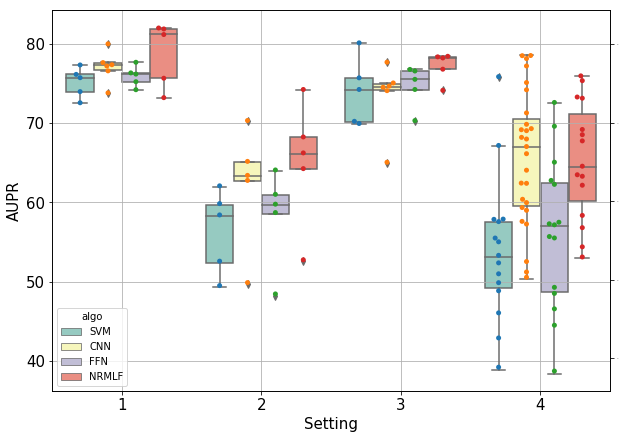

ratio_te :  2
	 1
	 NN-currDBH
		 ROCAUC
None /// 1 ; nan // 2 ; nan // 5 ; nan // 
	 NN-currPCBA
		 ROCAUC
None /// 1 ; nan // 2 ; nan // 5 ; nan // 
	 FFN
		 ROCAUC
5 /// 1 ; 59.794 // 2 ; 69.054 // 5 ; 74.626 // 
	 SVM
		 ROCAUC
5 /// 1 ; 73.188 // 2 ; 73.976 // 5 ; 74.95 // 
	 CN-feaMLP
		 ROCAUC
None /// 1 ; nan // 2 ; nan // 5 ; nan // 
	 CN
		 ROCAUC
5 /// 1 ; 70.73 // 2 ; 73.695 // 5 ; 76.4983 // 
	 NRLMF
		 ROCAUC
1 /// 1 ; 78.876 // 2 ; 78.876 // 5 ; 78.876 // 
	 2
	 NN-currDBH
		 ROCAUC
None /// 1 ; nan // 2 ; nan // 5 ; nan // 
	 NN-currPCBA
		 ROCAUC
None /// 1 ; nan // 2 ; nan // 5 ; nan // 
	 FFN
		 ROCAUC
5 /// 1 ; 55.076 // 2 ; 53.39 // 5 ; 55.124 // 
	 SVM
		 ROCAUC
1 /// 1 ; 57.716 // 2 ; 56.252 // 5 ; 56.502 // 
	 CN-feaMLP
		 ROCAUC
None /// 1 ; nan // 2 ; nan // 5 ; nan // 
	 CN
		 ROCAUC
2 /// 1 ; 59.665 // 2 ; 60.408 // 5 ; 59.64 // 
	 NRLMF
		 ROCAUC
1 /// 1 ; 64.962 // 2 ; 64.962 // 5 ; 64.962 // 
	 3
	 NN-currDBH
		 ROCAUC
None /// 1 ; nan // 2 ; nan // 5 ; n

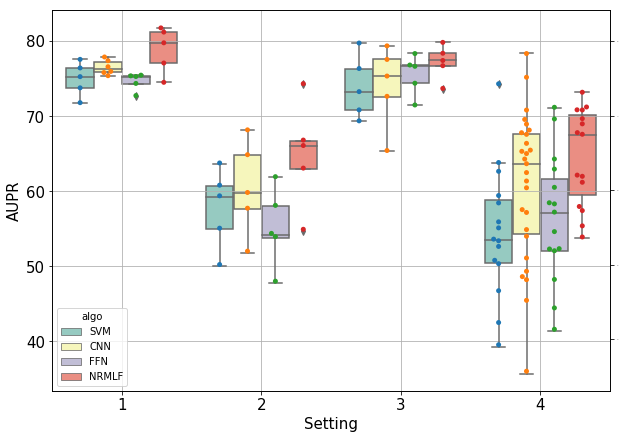

ratio_te :  5
	 1
	 NN-currDBH
		 ROCAUC
5 /// 1 ; nan // 2 ; nan // 5 ; 78.2367 // 
	 NN-currPCBA
		 ROCAUC
5 /// 1 ; nan // 2 ; nan // 5 ; 75.976 // 
	 FFN
		 ROCAUC
5 /// 1 ; 58.732 // 2 ; 68.016 // 5 ; 74.138 // 
	 SVM
		 ROCAUC
5 /// 1 ; 73.416 // 2 ; 74.0 // 5 ; 74.992 // 
	 CN-feaMLP
		 ROCAUC
5 /// 1 ; nan // 2 ; nan // 5 ; 76.426 // 
	 CN
		 ROCAUC
5 /// 1 ; 70.656 // 2 ; 72.672 // 5 ; 76.742 // 
	 NRLMF
		 ROCAUC
1 /// 1 ; 78.41 // 2 ; 78.41 // 5 ; 78.41 // 
	 2
	 NN-currDBH
		 ROCAUC
5 /// 1 ; nan // 2 ; nan // 5 ; 63.5775 // 
	 NN-currPCBA
		 ROCAUC
5 /// 1 ; nan // 2 ; nan // 5 ; 63.46 // 
	 FFN
		 ROCAUC
2 /// 1 ; 54.14 // 2 ; 55.08 // 5 ; 54.89 // 
	 SVM
		 ROCAUC
1 /// 1 ; 57.124 // 2 ; 55.99 // 5 ; 56.67 // 
	 CN-feaMLP
		 ROCAUC
5 /// 1 ; nan // 2 ; nan // 5 ; 60.426 // 
	 CN
		 ROCAUC
5 /// 1 ; 61.245 // 2 ; 61.98 // 5 ; 64.254 // 
	 NRLMF
		 ROCAUC
1 /// 1 ; 65.404 // 2 ; 65.404 // 5 ; 65.404 // 
	 3
	 NN-currDBH
		 ROCAUC
5 /// 1 ; nan // 2 ; nan // 5 ; 78.6425 // 

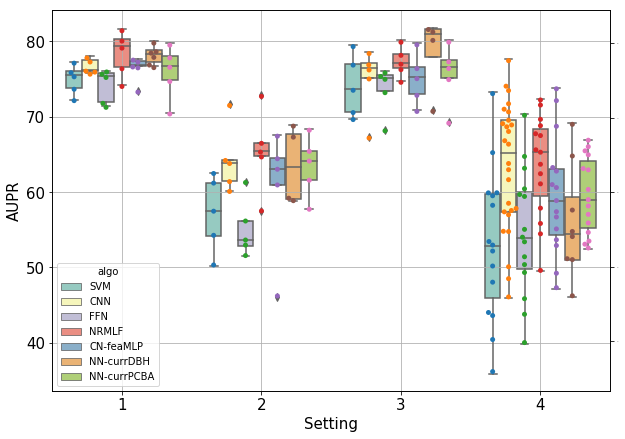

DrugBankECstand


In [52]:
DBECs_df_all_temp = DBECs_df_all[DBECs_df_all.score_name.isin(['ROCAUC'])]
DBECs_df_all_temp.replace(to_replace='feaSVM', value='SVM', inplace=True)
DBECs_df_all_temp.replace(to_replace='NRMLF', value='NRLMF', inplace=True)
DBECs_df_all_temp.replace(to_replace='NN', value='CN', inplace=True)
plot_perf('DrugBankECstand', DBECs_df_all_temp, ratio_tr=None, ratio_te=[1,2,5], setting=[1,2,3,4], figsize=(10,7),
          x_='setting', hue_='algo', print_perf=False, title_prefix='ROCAUC')
print_latex_tab('DrugBankECstand_ROCAUC.tex', dataset='DrugBankECstand', score_name='ROCAUC', df=DBECs_df_all_temp, 
                list_algo=['feaSVM', 'feaFFN', 'NRMLF', 'NN'],
                list_ratio_te=[1,2,5], list_ratio_tr=[1,2,5], list_setting=[1,2,3,4])

DrugBankECstand
ratio_te :  1
	 1
	 FFN
		 AUPR
5 /// 1 ; 63.032 // 2 ; 70.668 // 5 ; 79.816 // 
	 SVM
		 AUPR
5 /// 1 ; 80.252 // 2 ; 80.804 // 5 ; 81.752 // 
	 CN-currDBH
		 AUPR
None /// 1 ; nan // 2 ; nan // 5 ; nan // 
	 CN-currPCBA
		 AUPR
None /// 1 ; nan // 2 ; nan // 5 ; nan // 
	 CN-feaMLP
		 AUPR
None /// 1 ; nan // 2 ; nan // 5 ; nan // 
	 CN
		 AUPR
5 /// 1 ; 71.3233 // 2 ; 73.834 // 5 ; 79.0367 // 
	 NRLMF
		 AUPR
1 /// 1 ; 82.558 // 2 ; 82.558 // 5 ; 82.558 // 
	 2
	 FFN
		 AUPR
5 /// 1 ; 52.678 // 2 ; 55.768 // 5 ; 61.916 // 
	 SVM
		 AUPR
1 /// 1 ; 59.624 // 2 ; 59.266 // 5 ; 59.62 // 
	 CN-currDBH
		 AUPR
None /// 1 ; nan // 2 ; nan // 5 ; nan // 
	 CN-currPCBA
		 AUPR
None /// 1 ; nan // 2 ; nan // 5 ; nan // 
	 CN-feaMLP
		 AUPR
None /// 1 ; nan // 2 ; nan // 5 ; nan // 
	 CN
		 AUPR
1 /// 1 ; 62.274 // 2 ; 61.594 // 5 ; 60.79 // 
	 NRLMF
		 AUPR
2 /// 1 ; 67.558 // 2 ; 67.558 // 5 ; 67.558 // 
	 3
	 FFN
		 AUPR
5 /// 1 ; 62.1 // 2 ; 68.502 // 5 ; 78.568 // 
	 SVM
	

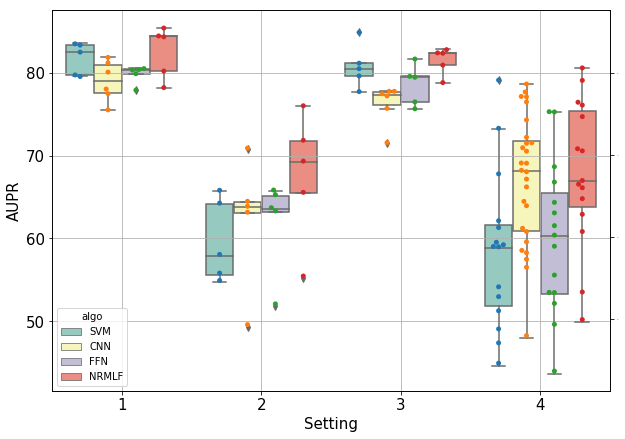

ratio_te :  2
	 1
	 FFN
		 AUPR
5 /// 1 ; 44.478 // 2 ; 54.586 // 5 ; 68.068 // 
	 SVM
		 AUPR
5 /// 1 ; 71.172 // 2 ; 71.862 // 5 ; 73.248 // 
	 CN-currDBH
		 AUPR
None /// 1 ; nan // 2 ; nan // 5 ; nan // 
	 CN-currPCBA
		 AUPR
None /// 1 ; nan // 2 ; nan // 5 ; nan // 
	 CN-feaMLP
		 AUPR
None /// 1 ; nan // 2 ; nan // 5 ; nan // 
	 CN
		 AUPR
5 /// 1 ; 54.8 // 2 ; 59.665 // 5 ; 66.4983 // 
	 NRLMF
		 AUPR
1 /// 1 ; 73.89 // 2 ; 73.89 // 5 ; 73.89 // 
	 2
	 FFN
		 AUPR
5 /// 1 ; 41.018 // 2 ; 40.392 // 5 ; 42.244 // 
	 SVM
		 AUPR
5 /// 1 ; 45.4 // 2 ; 45.482 // 5 ; 45.888 // 
	 CN-currDBH
		 AUPR
None /// 1 ; nan // 2 ; nan // 5 ; nan // 
	 CN-currPCBA
		 AUPR
None /// 1 ; nan // 2 ; nan // 5 ; nan // 
	 CN-feaMLP
		 AUPR
None /// 1 ; nan // 2 ; nan // 5 ; nan // 
	 CN
		 AUPR
2 /// 1 ; 44.185 // 2 ; 45.186 // 5 ; 45.106 // 
	 NRLMF
		 AUPR
2 /// 1 ; 53.178 // 2 ; 53.178 // 5 ; 53.178 // 
	 3
	 FFN
		 AUPR
5 /// 1 ; 45.078 // 2 ; 52.466 // 5 ; 68.14 // 
	 SVM
		 AUPR
5 /// 1 ; 70.8

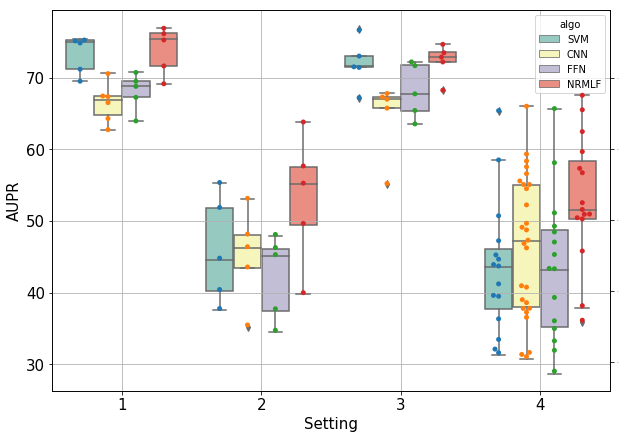

ratio_te :  5
	 1
	 FFN
		 AUPR
5 /// 1 ; 25.544 // 2 ; 32.048 // 5 ; 50.438 // 
	 SVM
		 AUPR
5 /// 1 ; 58.986 // 2 ; 59.876 // 5 ; 61.546 // 
	 CN-currDBH
		 AUPR
5 /// 1 ; nan // 2 ; nan // 5 ; 52.8883 // 
	 CN-currPCBA
		 AUPR
5 /// 1 ; nan // 2 ; nan // 5 ; 47.41 // 
	 CN-feaMLP
		 AUPR
5 /// 1 ; nan // 2 ; nan // 5 ; 53.492 // 
	 CN
		 AUPR
5 /// 1 ; 33.332 // 2 ; 38.59 // 5 ; 49.084 // 
	 NRLMF
		 AUPR
1 /// 1 ; 59.888 // 2 ; 59.888 // 5 ; 59.888 // 
	 2
	 FFN
		 AUPR
5 /// 1 ; 22.544 // 2 ; 23.464 // 5 ; 24.26 // 
	 SVM
		 AUPR
5 /// 1 ; 27.428 // 2 ; 28.22 // 5 ; 28.952 // 
	 CN-currDBH
		 AUPR
5 /// 1 ; nan // 2 ; nan // 5 ; 29.03 // 
	 CN-currPCBA
		 AUPR
5 /// 1 ; nan // 2 ; nan // 5 ; 28.792 // 
	 CN-feaMLP
		 AUPR
5 /// 1 ; nan // 2 ; nan // 5 ; 30.666 // 
	 CN
		 AUPR
5 /// 1 ; 26.8483 // 2 ; 28.028 // 5 ; 28.382 // 
	 NRLMF
		 AUPR
1 /// 1 ; 35.616 // 2 ; 35.616 // 5 ; 35.616 // 
	 3
	 FFN
		 AUPR
5 /// 1 ; 24.404 // 2 ; 31.094 // 5 ; 49.35 // 
	 SVM
		 AUPR
5 /// 1 ; 5

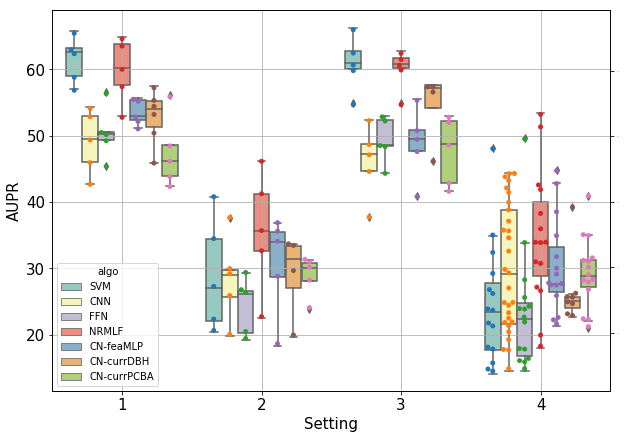

DrugBankECstand


In [53]:
DBECs_df_all_temp = DBECs_df_all[DBECs_df_all.score_name.isin(['AUPR'])]
DBECs_df_all_temp.replace(to_replace='feaSVM', value='SVM', inplace=True)
DBECs_df_all_temp.replace(to_replace='NN', value='CN', inplace=True)
DBECs_df_all_temp.replace(to_replace='NRMLF', value='NRLMF', inplace=True)

DBECs_df_all_temp.replace(to_replace='NN-currDBH', value='CN-currDBH', inplace=True)
DBECs_df_all_temp.replace(to_replace='NN-currPCBA', value='CN-currPCBA', inplace=True)
plot_perf('DrugBankECstand', DBECs_df_all_temp, ratio_tr=None, ratio_te=[1,2,5], setting=[1,2,3,4], figsize=(10,7),
          x_='setting', hue_='algo', print_perf=False, title_prefix='AUPR')
print_latex_tab('DrugBankECstand_AUPR.tex', dataset='DrugBankECstand', score_name='AUPR', df=DBECs_df_all_temp, 
                list_algo=['feaSVM', 'feaFFN', 'NRMLF', 'NN'],
                list_ratio_te=[1,2,5], list_ratio_tr=[1,2,5], list_setting=[1,2,3,4])

# DrugBank Human
process dataframes

In [54]:
DBHs_dfdti_best = df_NNdti[df_NNdti['dataset']=='DrugBankHstand'].copy()
lr_param = "2_bs:50;ne:100;lrs:{'name':'LearningRateScheduler','rate':0.9};lri:0.001;"
pred_param = 'prl:[100];prd:0.0;prr:0.0;pred_BN:True;'
DBHs_dfdti_best = DBHs_dfdti_best[DBHs_dfdti_best['lr_param']==lr_param]
DBHs_dfdti_best = DBHs_dfdti_best[DBHs_dfdti_best['pred_param']==pred_param]

enc_param = "j:{'name':'concat','hand_crafted_features':0,'reg':0}"
DBHs_dfdti_best = DBHs_dfdti_best[DBHs_dfdti_best['enc_param'].str.contains(enc_param)]
enc_param = "penc:{'name':'conv','n_steps':3,'nb_conv_filters':100,'filter_size':8,'conv_strides':3"+\
    ",'hand_crafted_features':0};mcurr:None;nconv:3;aggn:{'name':'standard','n_filters':100,'n_heads':5}"+\
    ";agga:{'name':'sum','pool_name':'standard','reg':0,'drop':0,'n_atoms':0};"+\
    "comb:{'name':'sum','hand_crafted_features':0};pB:True;pd:0.0;pr:0.0;mB:True;md:0.0;mr:0.0;"
DBHs_dfdti_best = DBHs_dfdti_best[DBHs_dfdti_best['enc_param'].str.contains(enc_param)]

DBHs_dfdti_best = DBHs_dfdti_best[DBHs_dfdti_best.score_name.isin(['ROCAUC', 'AUPR'])]
DBHs_dfdti_best.head(2)

,dataset,setting,ratio_tr,ratio_te,algo,lr_param,enc_param,pred_param,ite,ival,score_val,score_name
20,DrugBankHstand,4,5,1,NN,2_bs:50;ne:100;lrs:{'name':'LearningRateSchedu...,"j:{'name':'concat','hand_crafted_features':0,'...",prl:[100];prd:0.0;prr:0.0;pred_BN:True;,9,10,73.79,AUPR
21,DrugBankHstand,4,5,1,NN,2_bs:50;ne:100;lrs:{'name':'LearningRateSchedu...,"j:{'name':'concat','hand_crafted_features':0,'...",prl:[100];prd:0.0;prr:0.0;pred_BN:True;,9,10,73.00,ROCAUC


In [55]:
## restrict to ratio_tr < 5
DBHs_dfdti_best = DBHs_dfdti_best[DBHs_dfdti_best.ratio_tr.isin([1,2,5])]

In [58]:
DBHs_dfdti_best[(DBHs_dfdti_best["setting"]==2) & (DBHs_dfdti_best["ratio_tr"]==2) & (DBHs_dfdti_best["ratio_te"]==2)]

,dataset,setting,ratio_tr,ratio_te,algo,lr_param,enc_param,pred_param,ite,ival,score_val,score_name
115,DrugBankHstand,2,2,2,NN,2_bs:50;ne:100;lrs:{'name':'LearningRateSchedu...,"j:{'name':'concat','hand_crafted_features':0,'...",prl:[100];prd:0.0;prr:0.0;pred_BN:True;,2,3,66.42,AUPR
116,DrugBankHstand,2,2,2,NN,2_bs:50;ne:100;lrs:{'name':'LearningRateSchedu...,"j:{'name':'concat','hand_crafted_features':0,'...",prl:[100];prd:0.0;prr:0.0;pred_BN:True;,2,3,79.71,ROCAUC
2770,DrugBankHstand,2,2,2,NN,2_bs:50;ne:100;lrs:{'name':'LearningRateSchedu...,"j:{'name':'concat','hand_crafted_features':0,'...",prl:[100];prd:0.0;prr:0.0;pred_BN:True;,4,0,70.60,AUPR
2771,DrugBankHstand,2,2,2,NN,2_bs:50;ne:100;lrs:{'name':'LearningRateSchedu...,"j:{'name':'concat','hand_crafted_features':0,'...",prl:[100];prd:0.0;prr:0.0;pred_BN:True;,4,0,82.21,ROCAUC
3597,DrugBankHstand,2,2,2,NN,2_bs:50;ne:100;lrs:{'name':'LearningRateSchedu...,"j:{'name':'concat','hand_crafted_features':0,'...",prl:[100];prd:0.0;prr:0.0;pred_BN:True;,1,2,62.76,AUPR
3598,DrugBankHstand,2,2,2,NN,2_bs:50;ne:100;lrs:{'name':'LearningRateSchedu...,"j:{'name':'concat','hand_crafted_features':0,'...",prl:[100];prd:0.0;prr:0.0;pred_BN:True;,1,2,76.40,ROCAUC
3937,DrugBankHstand,2,2,2,NN,2_bs:50;ne:100;lrs:{'name':'LearningRateSchedu...,"j:{'name':'concat','hand_crafted_features':0,'...",prl:[100];prd:0.0;prr:0.0;pred_BN:True;,0,1,56.93,AUPR
3938,DrugBankHstand,2,2,2,NN,2_bs:50;ne:100;lrs:{'name':'LearningRateSchedu...,"j:{'name':'concat','hand_crafted_features':0,'...",prl:[100];prd:0.0;prr:0.0;pred_BN:True;,0,1,75.68,ROCAUC
5067,DrugBankHstand,2,2,2,NN,2_bs:50;ne:100;lrs:{'name':'LearningRateSchedu...,"j:{'name':'concat','hand_crafted_features':0,'...",prl:[100];prd:0.0;prr:0.0;pred_BN:True;,3,4,67.55,AUPR
5068,DrugBankHstand,2,2,2,NN,2_bs:50;ne:100;lrs:{'name':'LearningRateSchedu...,"j:{'name':'concat','hand_crafted_features':0,'...",prl:[100];prd:0.0;prr:0.0;pred_BN:True;,3,4,79.79,ROCAUC


In [59]:
dict_combi = {}
# count the combination of folds
for dataset in list(DBHs_dfdti_best.dataset.unique()):
    print("dataset", dataset)
    dict_combi[dataset] = {}
    df_t = DBHs_dfdti_best[DBHs_dfdti_best['dataset']==dataset]
    for setting in list(DBHs_dfdti_best.setting.unique()):
        nfolds = 5 if setting in [1,2,3] else 25
        print("setting", setting)
        dict_combi[dataset][setting] = {}
        df_tt = df_t[df_t['setting']==setting]
        for ratio_tr in list(DBHs_dfdti_best.ratio_tr.unique()):
            print("\tratio_tr", ratio_tr)
            dict_combi[dataset][setting][ratio_tr] = {}
            df_ttt = df_tt[df_tt['ratio_tr']==ratio_tr]
            for ratio_te in list(DBHs_dfdti_best.ratio_te.unique()):
                print("\t\tratio_te", ratio_te)
                dict_combi[dataset][setting][ratio_tr][ratio_te] = []
                df_tttt = df_ttt[df_ttt['ratio_te']==ratio_te]
                for index, row in df_tttt.iterrows():
                    ite, ival = row['ite'], row['ival']
                    if (ite, ival) not in dict_combi[dataset][setting][ratio_tr][ratio_te] and ival==((ite+1)%nfolds):
                        dict_combi[dataset][setting][ratio_tr][ratio_te].append((ite, ival))
                print(len(dict_combi[dataset][setting][ratio_tr][ratio_te]), dict_combi[dataset][setting][ratio_tr][ratio_te])


dataset DrugBankHstand
setting 4
	ratio_tr 5
		ratio_te 1
15 [(9, 10), (0, 1), (2, 3), (5, 6), (12, 13), (7, 8), (6, 7), (4, 5), (3, 4), (8, 9), (1, 2), (10, 11), (13, 14), (14, 15), (11, 12)]
		ratio_te 5
15 [(4, 5), (3, 4), (2, 3), (6, 7), (1, 2), (10, 11), (5, 6), (14, 15), (7, 8), (13, 14), (8, 9), (11, 12), (0, 1), (9, 10), (12, 13)]
		ratio_te 2
15 [(2, 3), (7, 8), (12, 13), (10, 11), (5, 6), (8, 9), (11, 12), (4, 5), (6, 7), (14, 15), (9, 10), (3, 4), (0, 1), (13, 14), (1, 2)]
	ratio_tr 1
		ratio_te 1
15 [(8, 9), (6, 7), (0, 1), (7, 8), (12, 13), (10, 11), (3, 4), (4, 5), (11, 12), (14, 15), (9, 10), (5, 6), (1, 2), (2, 3), (13, 14)]
		ratio_te 5
15 [(10, 11), (1, 2), (4, 5), (8, 9), (11, 12), (12, 13), (14, 15), (0, 1), (6, 7), (9, 10), (5, 6), (7, 8), (2, 3), (13, 14), (3, 4)]
		ratio_te 2
15 [(14, 15), (13, 14), (6, 7), (1, 2), (12, 13), (4, 5), (11, 12), (5, 6), (7, 8), (2, 3), (8, 9), (9, 10), (3, 4), (10, 11), (0, 1)]
	ratio_tr 2
		ratio_te 1
15 [(14, 15), (12, 13), (13, 1

In [60]:
DBHs_df_feaFFN_best = df_feaFFN[df_feaFFN['dataset']=='DrugBankHstand'].copy()
lr_param = "bs:100;n:100;p:20;ilr:0.001;lrs:{'name':'LearningRateScheduler','rate':0.9}"
enc_param = "l:[2000,1000,100];BN:True;d:0.0;r:0.0"

#df_feaFFN_best = df_feaFFN_best[df_feaFFN_best.enc_param.str.contains(enc_param)]

DBHs_df_feaFFN_best = DBHs_df_feaFFN_best[DBHs_df_feaFFN_best.lr_param.str.contains(lr_param)]

## restrict to ratio_tr < 5
DBHs_df_feaFFN_best = DBHs_df_feaFFN_best[DBHs_df_feaFFN_best.ratio_tr.isin([1,2,5])]

DBHs_df_feaFFN_best = DBHs_df_feaFFN_best[DBHs_df_feaFFN_best.dataset.isin(['DrugBankHstand'])]  
DBHs_df_feaFFN_best = DBHs_df_feaFFN_best[DBHs_df_feaFFN_best.score_name.isin(['ROCAUC', 'AUPR'])]             

In [61]:
DBHs_df_feaFFN_best.head(5)

,dataset,setting,ratio_tr,ratio_te,algo,lr_param,enc_param,score_val,score_name,ite,ival
15,DrugBankHstand,4,5,1,FFN,bs:100;n:100;p:20;ilr:0.001;lrs:{'name':'Learn...,"l:[2000,1000,100];BN:True;d:0.0;r:0.0.data",70.25,AUPR,9,10
16,DrugBankHstand,4,5,1,FFN,bs:100;n:100;p:20;ilr:0.001;lrs:{'name':'Learn...,"l:[2000,1000,100];BN:True;d:0.0;r:0.0.data",66.22,ROCAUC,9,10
25,DrugBankHstand,4,1,1,FFN,bs:100;n:100;p:20;ilr:0.001;lrs:{'name':'Learn...,"l:[2000,1000,100];BN:True;d:0.0;r:0.0.data",71.86,AUPR,8,9
26,DrugBankHstand,4,1,1,FFN,bs:100;n:100;p:20;ilr:0.001;lrs:{'name':'Learn...,"l:[2000,1000,100];BN:True;d:0.0;r:0.0.data",69.85,ROCAUC,8,9
60,DrugBankHstand,4,5,5,FFN,bs:100;n:100;p:20;ilr:0.001;lrs:{'name':'Learn...,"l:[2000,1000,100];BN:True;d:0.0;r:0.0.data",38.76,AUPR,21,6


DBHs_dfdti_best[(DBHs_dfdti_best["setting"]==2) & (DBHs_dfdti_best["ratio_tr"]==2) & (DBHs_dfdti_best["ratio_te"]==2)]

In [62]:
df_feaSVM['lr_param']=None
df_feaSVM['enc_param']=None
df_feaSVM['pred_param']=None

df_NRMLF['lr_param']=None
df_NRMLF['enc_param']=None
df_NRMLF['pred_param']=None

DBHs_df_feaFFN_best['pred_param']=None

In [64]:
##### intégrer dernier algo
DBH_MLP = df_NNdti.copy()
DBH_MLP = DBH_MLP[DBH_MLP['dataset']=='DrugBankHstand']

#lr_param = "bs:100;ne:100;lrs:{'name':'LearningRateScheduler','rate':0.9};lri:0.001;"
#pred_param = 'prl:[100];prd:0.0;prr:0.0;pred_BN:True;'
#DBEC_extra = DBEC_extra[DBEC_extra['lr_param']==lr_param]
#DBEC_extra = DBEC_extra[DBEC_extra['pred_param']==pred_param]
#enc_param = "j:{'name':'concat','hand_crafted_features':0,'reg':0};slen:None;pcurr:None;penc:{'name':'conv','n_steps':2,'nb_conv_filters':100,'filter_size':12,'conv_strides':3,'hand_crafted_features':0};mcurr:None;nconv:3;aggn:{'name':'standard','n_filters':50,'n_heads':5};agga:{'name':'sum'};comb:{'name':'sum','hand_crafted_features':0};"
enc_param = "j:{'name':'concat','hand_crafted_features':200"

#$HOME/conda3/envs/tfgpu/bin/python src/experiments/mol_experiments.py -db DrugBankECstand -nf 5 -tef 4 -valf 0 
#-set 1 -rtr 5 -rte 5 --batch_size 100 --n_epochs 100 --init_lr 0.001 --patience_early_stopping 20 --lr_scheduler 
#'{"name": "LearningRateScheduler", "rate": 0.9}' --pred_layers 0 --pred_dropout 0 --pred_reg 0 --seq_len 0 
#--p_encoder '{"name": "conv", "n_steps": 3, "nb_conv_filters": 100, "filter_size": 8, "conv_strides": 3, 
#"hand_crafted_features": 0}' --p_dropout 0 --p_reg 0 -pbn  --m_n_att_atom 0 --m_n_steps 3 --m_agg_nei 
#    '{"name": "standard", "n_filters": 100, "n_heads": 5}' --m_agg_all '{"name": "sum", "pool_name": "standard", 
#    "reg": 0, "drop": 0, "n_atoms": 0}' --m_combine '{"name": "sum", "hand_crafted_features": 0}' -md 0 -mr 0 
#                -mbn --dti_joint '{"name": "concat", "hand_crafted_features": 200, "reg": 0}' --pred_batchnorm
#                -t 3 -wgen 10 -qgen 100 -spr -spe


DBH_MLP = DBH_MLP[DBH_MLP['enc_param'].str.contains(enc_param)]

#enc_param = "j:{'name':'concat','hand_crafted_features':0,'reg':0}"
#DBEC_extra = DBEC_extra[DBEC_extra['enc_param'].str.contains(enc_param)]

DBH_MLP = DBH_MLP[DBH_MLP.score_name.isin(['ROCAUC', 'AUPR'])]

DBH_MLP['algo'] = 'NN-feaMLP'
DBH_MLP[DBH_MLP['setting']==2].head(5)

,dataset,setting,ratio_tr,ratio_te,algo,lr_param,enc_param,pred_param,ite,ival,score_val,score_name
1470,DrugBankHstand,2,5,5,NN-feaMLP,3_bs:100;ne:100;lrs:{'name':'LearningRateSched...,"j:{'name':'concat','hand_crafted_features':200...",prl:[0];prd:0.0;prr:0.0;pred_BN:True;,3,4,49.89,AUPR
1471,DrugBankHstand,2,5,5,NN-feaMLP,3_bs:100;ne:100;lrs:{'name':'LearningRateSched...,"j:{'name':'concat','hand_crafted_features':200...",prl:[0];prd:0.0;prr:0.0;pred_BN:True;,3,4,74.73,ROCAUC
2635,DrugBankHstand,2,5,5,NN-feaMLP,3_bs:100;ne:100;lrs:{'name':'LearningRateSched...,"j:{'name':'concat','hand_crafted_features':200...",prl:[0];prd:0.0;prr:0.0;pred_BN:True;,0,1,48.31,AUPR
2636,DrugBankHstand,2,5,5,NN-feaMLP,3_bs:100;ne:100;lrs:{'name':'LearningRateSched...,"j:{'name':'concat','hand_crafted_features':200...",prl:[0];prd:0.0;prr:0.0;pred_BN:True;,0,1,76.66,ROCAUC
3627,DrugBankHstand,2,5,5,NN-feaMLP,3_bs:100;ne:100;lrs:{'name':'LearningRateSched...,"j:{'name':'concat','hand_crafted_features':200...",prl:[0];prd:0.0;prr:0.0;pred_BN:True;,2,3,50.95,AUPR


In [65]:
# restrict other df to specific ival et ite
df_feaSVM_limited = {el: [] for el in list(df_feaSVM.columns.values)}
df_NRMLF_limited = {el: [] for el in list(df_NRMLF.columns.values)}
DBHs_df_feaFFN_best_limited = {el: [] for el in list(DBHs_df_feaFFN_best.columns.values)}
DBH_MLP_limited = {el: [] for el in list(DBH_MLP.columns.values)}

# count the combination of folds
for dataset in list(dict_combi.keys()):
    print("dataset", dataset)
    df_t = df_feaSVM[df_feaSVM['dataset']==dataset]
    for setting in list(dict_combi[dataset].keys()):
        nfolds = 5 if setting in [1,2,3] else 25
        print("setting", setting)
        df_tt = df_t[df_t['setting']==setting]
        for ratio_tr in list(dict_combi[dataset][setting].keys()):
          if ratio_tr in [1,2,5]:
            print("\tratio_tr", ratio_tr)
            df_ttt = df_tt[df_tt['ratio_tr']==ratio_tr]
            for ratio_te in list(dict_combi[dataset][setting][ratio_tr].keys()):
                print("\t\tratio_te", ratio_te)
                df_tttt = df_ttt[df_ttt['ratio_te']==ratio_te]
                for index, row in df_tttt.iterrows():
                    ite, ival = row['ite'], row['ival']
                    if (ite, ival) in dict_combi[dataset][setting][ratio_tr][ratio_te]:
                        for cle, val in row.items():
                            df_feaSVM_limited[cle].append(val)
                    
for dataset in list(dict_combi.keys()):
    print("dataset", dataset)
    df_t = df_NRMLF[df_NRMLF['dataset']==dataset]
    for setting in list(dict_combi[dataset].keys()):
        nfolds = 5 if setting in [1,2,3] else 25
        print("setting", setting)
        df_tt = df_t[df_t['setting']==setting]
        for ratio_tr in list(dict_combi[dataset][setting].keys()):
          if ratio_tr in [1,2,5]:
            print("\tratio_tr", ratio_tr)
            df_ttt = df_tt[df_tt['ratio_tr']==ratio_tr]
            for ratio_te in list(dict_combi[dataset][setting][ratio_tr].keys()):
                print("\t\tratio_te", ratio_te)
                df_tttt = df_ttt[df_ttt['ratio_te']==ratio_te]
                for index, row in df_tttt.iterrows():
                    ite, ival = row['ite'], row['ival']
                    if (ite, ival) in dict_combi[dataset][setting][ratio_tr][ratio_te]:
                        for cle, val in row.items():
                            df_NRMLF_limited[cle].append(val)

for dataset in list(dict_combi.keys()):
    print("dataset", dataset)
    df_t = DBHs_df_feaFFN_best[DBHs_df_feaFFN_best['dataset']==dataset]
    for setting in list(dict_combi[dataset].keys()):
        nfolds = 5 if setting in [1,2,3] else 25
        print("setting", setting)
        df_tt = df_t[df_t['setting']==setting]
        for ratio_tr in list(dict_combi[dataset][setting].keys()):
          #if ratio_tr in [1,2,5]:
            print("\tratio_tr", ratio_tr)
            df_ttt = df_tt[df_tt['ratio_tr']==ratio_tr]
            for ratio_te in list(dict_combi[dataset][setting][ratio_tr].keys()):
                print("\t\tratio_te", ratio_te)
                df_tttt = df_ttt[df_ttt['ratio_te']==ratio_te]
                for index, row in df_tttt.iterrows():
                    ite, ival = row['ite'], row['ival']
                    if (ite, ival) in dict_combi[dataset][setting][ratio_tr][ratio_te]:
                        for cle, val in row.items():
                            DBHs_df_feaFFN_best_limited[cle].append(val)  
                            
for dataset in list(dict_combi.keys()):
    print("dataset", dataset)
    df_t = DBH_MLP[DBH_MLP['dataset']==dataset]
    for setting in list(dict_combi[dataset].keys()):
        nfolds = 5 if setting in [1,2,3] else 25
        print("setting", setting)
        df_tt = df_t[df_t['setting']==setting]
        for ratio_tr in list(dict_combi[dataset][setting].keys()):
          #if ratio_tr in [1,2,5]:
            print("\tratio_tr", ratio_tr)
            df_ttt = df_tt[df_tt['ratio_tr']==ratio_tr]
            for ratio_te in list(dict_combi[dataset][setting][ratio_tr].keys()):
                print("\t\tratio_te", ratio_te)
                df_tttt = df_ttt[df_ttt['ratio_te']==ratio_te]
                for index, row in df_tttt.iterrows():
                    ite, ival = row['ite'], row['ival']
                    if (ite, ival) in dict_combi[dataset][setting][ratio_tr][ratio_te]:
                        for cle, val in row.items():
                            DBH_MLP_limited[cle].append(val)  

df_feaSVM_limited = pd.DataFrame(df_feaSVM_limited)
df_NRMLF_limited = pd.DataFrame(df_NRMLF_limited)
DBHs_df_feaFFN_best_limited = pd.DataFrame(DBHs_df_feaFFN_best_limited)
DBH_MLP_limited = pd.DataFrame(DBH_MLP_limited)

dataset DrugBankHstand
setting 4
	ratio_tr 5
		ratio_te 1
		ratio_te 5
		ratio_te 2
	ratio_tr 1
		ratio_te 1
		ratio_te 5
		ratio_te 2
	ratio_tr 2
		ratio_te 1
		ratio_te 5
		ratio_te 2
setting 1
	ratio_tr 5
		ratio_te 1
		ratio_te 5
		ratio_te 2
	ratio_tr 1
		ratio_te 1
		ratio_te 5
		ratio_te 2
	ratio_tr 2
		ratio_te 1
		ratio_te 5
		ratio_te 2
setting 2
	ratio_tr 5
		ratio_te 1
		ratio_te 5
		ratio_te 2
	ratio_tr 1
		ratio_te 1
		ratio_te 5
		ratio_te 2
	ratio_tr 2
		ratio_te 1
		ratio_te 5
		ratio_te 2
setting 3
	ratio_tr 5
		ratio_te 1
		ratio_te 5
		ratio_te 2
	ratio_tr 1
		ratio_te 1
		ratio_te 5
		ratio_te 2
	ratio_tr 2
		ratio_te 1
		ratio_te 5
		ratio_te 2
dataset DrugBankHstand
setting 4
	ratio_tr 5
		ratio_te 1
		ratio_te 5
		ratio_te 2
	ratio_tr 1
		ratio_te 1
		ratio_te 5
		ratio_te 2
	ratio_tr 2
		ratio_te 1
		ratio_te 5
		ratio_te 2
setting 1
	ratio_tr 5
		ratio_te 1
		ratio_te 5
		ratio_te 2
	ratio_tr 1
		ratio_te 1
		ratio_te 5
		ratio_te 2
	ratio_tr 2
		ratio_te 1
		

In [66]:
#DBHs_df_all = pd.concat([df_feaSVM_limited, DBHs_dfdti_best, DBHs_df_feaFFN_best_limited, df_NRMLF_limited])

DBHs_df_all = pd.concat([df_feaSVM_limited, DBHs_dfdti_best, DBHs_df_feaFFN_best_limited, df_NRMLF_limited, DBH_MLP_limited])

/home/beubeu/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  This is separate from the ipykernel package so we can avoid doing imports until


In [67]:
DBHs_df_all.head(5)

,algo,dataset,enc_param,ite,ival,lr_param,pred_param,ratio_te,ratio_tr,score_name,score_val,setting
0,feaSVM,DrugBankHstand,None,9,10,None,None,1,5,AUPR,49.84,4
1,feaSVM,DrugBankHstand,None,9,10,None,None,1,5,ROCAUC,50.65,4
2,feaSVM,DrugBankHstand,None,9,10,None,None,1,5,Precision,0.00,4
3,feaSVM,DrugBankHstand,None,9,10,None,None,1,5,Recall,0.00,4
4,feaSVM,DrugBankHstand,None,9,10,None,None,1,5,F1,0.00,4


# DrugBank Human
plot results

DrugBankHstand
ratio_te :  1
	 1
	 FFN
		 ROCAUC
5 /// 1 ; 86.732 // 2 ; 88.982 // 5 ; 90.386 // 
	 SVM
		 ROCAUC
2 /// 1 ; 74.706 // 2 ; 75.066 // 5 ; 74.596 // 
	 CN
		 ROCAUC
5 /// 1 ; 84.854 // 2 ; 86.34 // 5 ; 88.668 // 
	 NRLMF
		 ROCAUC
2 /// 1 ; 82.974 // 2 ; 82.976 // 5 ; 82.976 // 
	 NN-feaMLP
		 ROCAUC
None /// 1 ; nan // 2 ; nan // 5 ; nan // 
	 2
	 FFN
		 ROCAUC
5 /// 1 ; 71.486 // 2 ; 73.21 // 5 ; 74.744 // 
	 SVM
		 ROCAUC
5 /// 1 ; 49.05 // 2 ; 48.212 // 5 ; 50.262 // 
	 CN
		 ROCAUC
5 /// 1 ; 80.728 // 2 ; 80.86 // 5 ; 81.498 // 
	 NRLMF
		 ROCAUC
1 /// 1 ; 65.18 // 2 ; 65.18 // 5 ; 65.18 // 
	 NN-feaMLP
		 ROCAUC
None /// 1 ; nan // 2 ; nan // 5 ; nan // 
	 3
	 FFN
		 ROCAUC
2 /// 1 ; 81.158 // 2 ; 83.34 // 5 ; 83.06 // 
	 SVM
		 ROCAUC
2 /// 1 ; 74.89 // 2 ; 75.378 // 5 ; 75.162 // 
	 CN
		 ROCAUC
5 /// 1 ; 83.286 // 2 ; 84.48 // 5 ; 85.76 // 
	 NRLMF
		 ROCAUC
1 /// 1 ; 59.492 // 2 ; 59.492 // 5 ; 59.492 // 
	 NN-feaMLP
		 ROCAUC
None /// 1 ; nan // 2 ; nan // 5 ; n

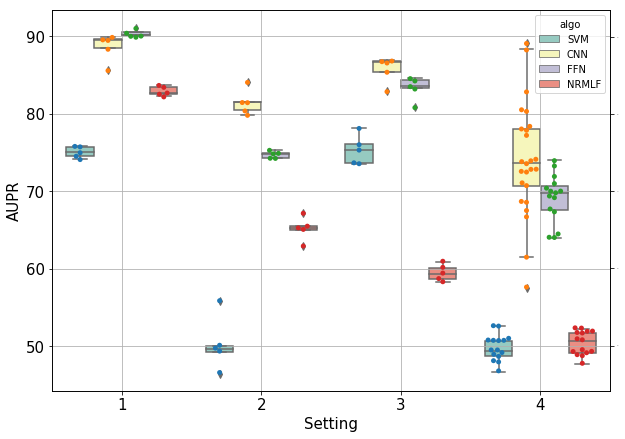

ratio_te :  2
	 1
	 FFN
		 ROCAUC
5 /// 1 ; 86.184 // 2 ; 89.174 // 5 ; 90.648 // 
	 SVM
		 ROCAUC
2 /// 1 ; 74.658 // 2 ; 75.078 // 5 ; 74.602 // 
	 CN
		 ROCAUC
5 /// 1 ; 84.542 // 2 ; 86.458 // 5 ; 88.206 // 
	 NRLMF
		 ROCAUC
1 /// 1 ; 83.066 // 2 ; 83.064 // 5 ; 83.064 // 
	 NN-feaMLP
		 ROCAUC
None /// 1 ; nan // 2 ; nan // 5 ; nan // 
	 2
	 FFN
		 ROCAUC
5 /// 1 ; 71.252 // 2 ; 73.202 // 5 ; 74.08 // 
	 SVM
		 ROCAUC
5 /// 1 ; 49.102 // 2 ; 47.988 // 5 ; 49.876 // 
	 CN
		 ROCAUC
5 /// 1 ; 78.41 // 2 ; 78.758 // 5 ; 80.83 // 
	 NRLMF
		 ROCAUC
1 /// 1 ; 65.176 // 2 ; 65.176 // 5 ; 65.176 // 
	 NN-feaMLP
		 ROCAUC
None /// 1 ; nan // 2 ; nan // 5 ; nan // 
	 3
	 FFN
		 ROCAUC
5 /// 1 ; 81.274 // 2 ; 82.82 // 5 ; 83.518 // 
	 SVM
		 ROCAUC
2 /// 1 ; 75.036 // 2 ; 75.518 // 5 ; 75.28 // 
	 CN
		 ROCAUC
5 /// 1 ; 84.412 // 2 ; 83.896 // 5 ; 85.404 // 
	 NRLMF
		 ROCAUC
1 /// 1 ; 59.558 // 2 ; 59.558 // 5 ; 59.558 // 
	 NN-feaMLP
		 ROCAUC
None /// 1 ; nan // 2 ; nan // 5 ; nan // 
	

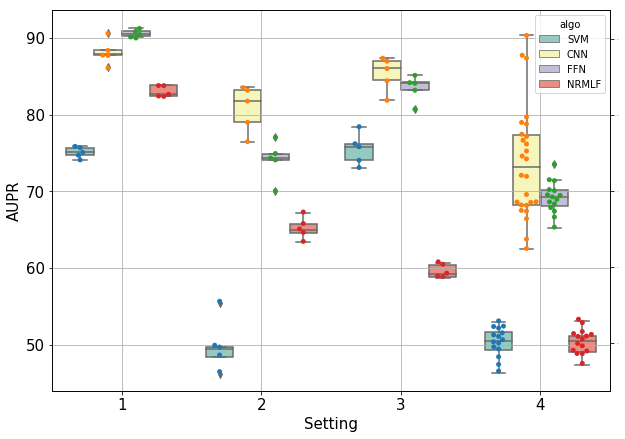

ratio_te :  5
	 1
	 FFN
		 ROCAUC
5 /// 1 ; 86.362 // 2 ; 89.188 // 5 ; 90.452 // 
	 SVM
		 ROCAUC
2 /// 1 ; 74.666 // 2 ; 75.13 // 5 ; 74.618 // 
	 CN
		 ROCAUC
5 /// 1 ; 84.012 // 2 ; 85.344 // 5 ; 88.212 // 
	 NRLMF
		 ROCAUC
1 /// 1 ; 83.122 // 2 ; 83.12 // 5 ; 83.122 // 
	 NN-feaMLP
		 ROCAUC
5 /// 1 ; nan // 2 ; nan // 5 ; 90.092 // 
	 2
	 FFN
		 ROCAUC
5 /// 1 ; 71.504 // 2 ; 72.918 // 5 ; 74.254 // 
	 SVM
		 ROCAUC
2 /// 1 ; 49.346 // 2 ; 50.06 // 5 ; 49.876 // 
	 CN
		 ROCAUC
5 /// 1 ; 78.464 // 2 ; 80.042 // 5 ; 80.278 // 
	 NRLMF
		 ROCAUC
1 /// 1 ; 65.228 // 2 ; 65.22 // 5 ; 65.228 // 
	 NN-feaMLP
		 ROCAUC
5 /// 1 ; nan // 2 ; nan // 5 ; 75.168 // 
	 3
	 FFN
		 ROCAUC
2 /// 1 ; 80.93 // 2 ; 82.96 // 5 ; 82.898 // 
	 SVM
		 ROCAUC
2 /// 1 ; 74.956 // 2 ; 75.392 // 5 ; 75.136 // 
	 CN
		 ROCAUC
5 /// 1 ; 83.7367 // 2 ; 83.74 // 5 ; 85.758 // 
	 NRLMF
		 ROCAUC
1 /// 1 ; 59.598 // 2 ; 59.598 // 5 ; 59.598 // 
	 NN-feaMLP
		 ROCAUC
5 /// 1 ; nan // 2 ; nan // 5 ; 84.734 // 
	 

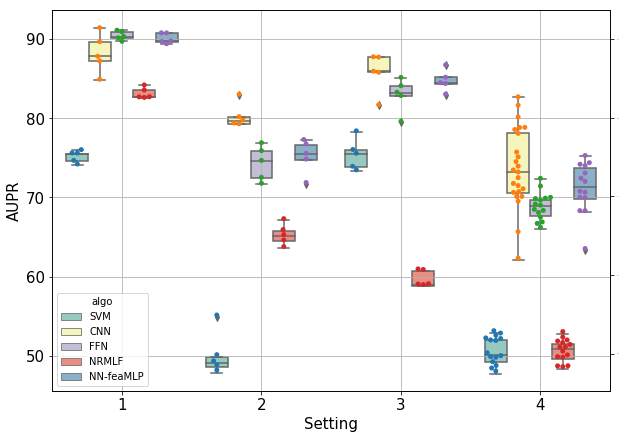

In [68]:
DBHs_df_all_temp = DBHs_df_all[DBHs_df_all.score_name.isin(['ROCAUC'])]
DBHs_df_all_temp.replace('feaSVM', 'SVM', True)
DBHs_df_all_temp.replace(to_replace='NRMLF', value='NRLMF', inplace=True)
DBHs_df_all_temp.replace('NN', 'CN', True)
plot_perf('DrugBankHstand', DBHs_df_all_temp, ratio_tr=None, ratio_te=[1,2,5], setting=[1,2,3,4], figsize=(10,7),
          x_='setting', hue_='algo', print_perf=False, title_prefix='ROCAUC ')

DrugBankHstand
ratio_te :  1
	 1
	 FFN
		 AUPR
5 /// 1 ; 85.35 // 2 ; 89.008 // 5 ; 91.446 // 
	 SVM
		 AUPR
5 /// 1 ; 77.928 // 2 ; 78.222 // 5 ; 78.344 // 
	 CN-feaMLP
		 AUPR
None /// 1 ; nan // 2 ; nan // 5 ; nan // 
	 CN
		 AUPR
5 /// 1 ; 83.02 // 2 ; 85.386 // 5 ; 88.74 // 
	 NRLMF
		 AUPR
2 /// 1 ; 86.094 // 2 ; 86.138 // 5 ; 86.138 // 
	 2
	 FFN
		 AUPR
5 /// 1 ; 73.58 // 2 ; 76.012 // 5 ; 78.164 // 
	 SVM
		 AUPR
5 /// 1 ; 49.346 // 2 ; 48.6 // 5 ; 50.352 // 
	 CN-feaMLP
		 AUPR
None /// 1 ; nan // 2 ; nan // 5 ; nan // 
	 CN
		 AUPR
5 /// 1 ; 80.364 // 2 ; 80.2067 // 5 ; 81.824 // 
	 NRLMF
		 AUPR
2 /// 1 ; 68.208 // 2 ; 68.236 // 5 ; 68.194 // 
	 3
	 FFN
		 AUPR
5 /// 1 ; 80.61 // 2 ; 84.078 // 5 ; 85.694 // 
	 SVM
		 AUPR
5 /// 1 ; 77.624 // 2 ; 78.116 // 5 ; 78.2 // 
	 CN-feaMLP
		 AUPR
None /// 1 ; nan // 2 ; nan // 5 ; nan // 
	 CN
		 AUPR
5 /// 1 ; 82.76 // 2 ; 84.264 // 5 ; 85.996 // 
	 NRLMF
		 AUPR
2 /// 1 ; 61.842 // 2 ; 61.892 // 5 ; 61.878 // 
	 4
	 FFN
		 AUPR
5 

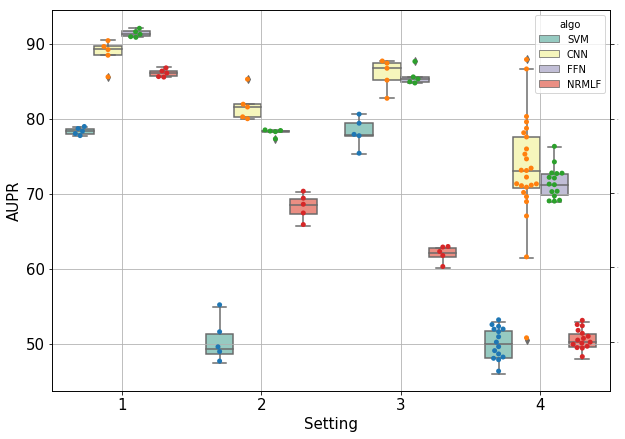

ratio_te :  2
	 1
	 FFN
		 AUPR
5 /// 1 ; 75.76 // 2 ; 81.944 // 5 ; 86.504 // 
	 SVM
		 AUPR
5 /// 1 ; 66.01 // 2 ; 66.574 // 5 ; 66.85 // 
	 CN-feaMLP
		 AUPR
None /// 1 ; nan // 2 ; nan // 5 ; nan // 
	 CN
		 AUPR
5 /// 1 ; 73.58 // 2 ; 74.186 // 5 ; 80.294 // 
	 NRLMF
		 AUPR
5 /// 1 ; 78.718 // 2 ; 78.668 // 5 ; 78.734 // 
	 2
	 FFN
		 AUPR
5 /// 1 ; 59.908 // 2 ; 63.364 // 5 ; 66.024 // 
	 SVM
		 AUPR
5 /// 1 ; 32.828 // 2 ; 32.024 // 5 ; 33.464 // 
	 CN-feaMLP
		 AUPR
None /// 1 ; nan // 2 ; nan // 5 ; nan // 
	 CN
		 AUPR
5 /// 1 ; 64.156 // 2 ; 64.852 // 5 ; 70.388 // 
	 NRLMF
		 AUPR
5 /// 1 ; 53.638 // 2 ; 53.666 // 5 ; 53.678 // 
	 3
	 FFN
		 AUPR
5 /// 1 ; 69.318 // 2 ; 74.156 // 5 ; 78.148 // 
	 SVM
		 AUPR
5 /// 1 ; 66.076 // 2 ; 66.722 // 5 ; 66.862 // 
	 CN-feaMLP
		 AUPR
None /// 1 ; nan // 2 ; nan // 5 ; nan // 
	 CN
		 AUPR
5 /// 1 ; 72.726 // 2 ; 71.748 // 5 ; 77.016 // 
	 NRLMF
		 AUPR
1 /// 1 ; 45.97 // 2 ; 45.958 // 5 ; 45.93 // 
	 4
	 FFN
		 AUPR
5 /// 1 ; 52.9

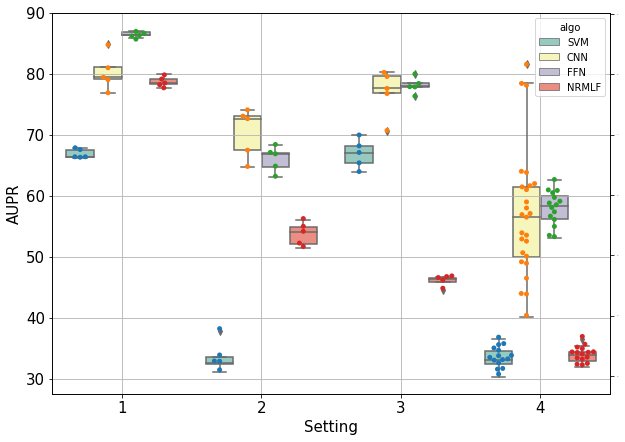

ratio_te :  5
	 1
	 FFN
		 AUPR
5 /// 1 ; 58.436 // 2 ; 68.08 // 5 ; 75.908 // 
	 SVM
		 AUPR
5 /// 1 ; 47.846 // 2 ; 48.516 // 5 ; 48.988 // 
	 CN-feaMLP
		 AUPR
5 /// 1 ; nan // 2 ; nan // 5 ; 74.206 // 
	 CN
		 AUPR
5 /// 1 ; 51.934 // 2 ; 54.446 // 5 ; 65.458 // 
	 NRLMF
		 AUPR
5 /// 1 ; 66.776 // 2 ; 66.926 // 5 ; 66.928 // 
	 2
	 FFN
		 AUPR
5 /// 1 ; 40.726 // 2 ; 44.91 // 5 ; 49.132 // 
	 SVM
		 AUPR
5 /// 1 ; 16.452 // 2 ; 16.796 // 5 ; 16.818 // 
	 CN-feaMLP
		 AUPR
5 /// 1 ; nan // 2 ; nan // 5 ; 48.816 // 
	 CN
		 AUPR
2 /// 1 ; 40.37 // 2 ; 48.378 // 5 ; 47.682 // 
	 NRLMF
		 AUPR
5 /// 1 ; 34.742 // 2 ; 34.738 // 5 ; 34.746 // 
	 3
	 FFN
		 AUPR
5 /// 1 ; 49.97 // 2 ; 57.518 // 5 ; 64.06 // 
	 SVM
		 AUPR
5 /// 1 ; 47.634 // 2 ; 48.268 // 5 ; 48.664 // 
	 CN-feaMLP
		 AUPR
5 /// 1 ; nan // 2 ; nan // 5 ; 65.41 // 
	 CN
		 AUPR
5 /// 1 ; 55.2917 // 2 ; 56.63 // 5 ; 62.216 // 
	 NRLMF
		 AUPR
5 /// 1 ; 26.418 // 2 ; 26.378 // 5 ; 26.42 // 
	 4
	 FFN
		 AUPR
5 /// 1 ; 32.72

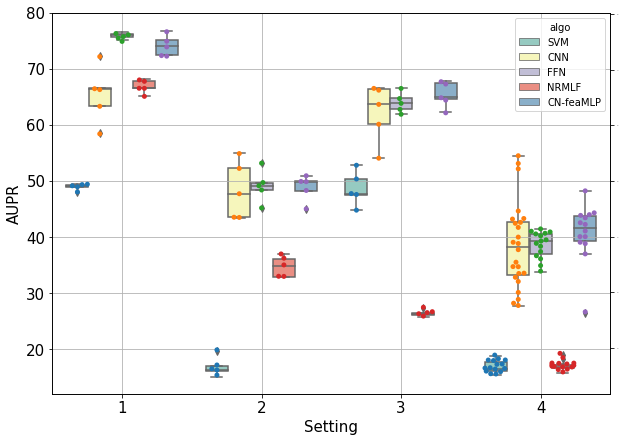

In [69]:
DBHs_df_all_temp = DBHs_df_all[DBHs_df_all.score_name.isin(['AUPR'])]
DBHs_df_all_temp.replace('feaSVM', 'SVM', True)
DBHs_df_all_temp.replace('NN', 'CN', True)
DBHs_df_all_temp.replace(to_replace='NRMLF', value='NRLMF', inplace=True)
DBHs_df_all_temp.replace('NN-feaMLP', 'CN-feaMLP', True)
plot_perf('DrugBankHstand', DBHs_df_all_temp, ratio_tr=None, ratio_te=[1,2,5], setting=[1,2,3,4], figsize=(10,7),
          x_='setting', hue_='algo', print_perf=False, title_prefix='AUPR ')